# In this notebook we try to merge the 2017 Births and Non Fetal Datasets and produce a logistic regression model

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings

warnings.filterwarnings("ignore")  # Suppress all warnings

C:\Users\ssbarincon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [127]:
#returns a dataframe with the 9,99 or 999 converted to null in the columns you can take max
def max9tonull(df):
    cols_tonull=df.max().index
    all_null=pd.DataFrame()
    cols=df.columns
    for i,col in enumerate(cols):
        if col in cols_tonull:
            maxi=df[col].max()
            maxisnull=np.where(np.isin(maxi,[9,99,999]),True,np.isin(maxi,['9','99','999','9.0','99.0','999.0']))
            print('yes',col)
            if maxisnull:
                all_null[col]=df[col].replace(to_replace=maxi, value=np.nan,regex=True)
            else:
                all_null[col]=df[col]
            #all_null[col]=np.where((df[col]==maxi)&maxisnull, np.nan, df[col])
        else:
            print('no',col)
            all_null[col]=df[col]
    return all_null

In [3]:
#returns the dataframe with the blanks converted to null
def emptytonull(df):
    return df.replace(to_replace=r'^\s*$', value=np.nan,regex=True)

# Import 2017

In [4]:
nac_2017= pd.read_csv('../Data/nac2017.csv',sep=';')
print(nac_2017.columns)
print(nac_2017.info())
nac_2017.describe()

Index(['COD_DPTO', 'COD_MUNIC', 'AREANAC', 'SIT_PARTO', 'OTRO_SIT', 'NOM_INST',
       'COD_INST', 'SEXO', 'PESO_NAC', 'TALLA_NAC', 'ANO', 'MES', 'ATEN_PAR',
       'OTRPARATX', 'T_GES', 'NUMCONSUL', 'TIPO_PARTO', 'MUL_PARTO', 'APGAR1',
       'APGAR2', 'IDHEMOCLAS', 'IDFACTORRH', 'IDPERTET', 'EDAD_MADRE',
       'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES', 'CODPTORE', 'CODMUNRE',
       'AREA_RES', 'N_HIJOSV', 'FECHA_NACM', 'N_EMB', 'SEG_SOCIAL',
       'IDCLASADMI', 'NOMCLASAD', 'EDAD_PADRE', 'NIV_EDUP', 'ULTCURPAD',
       'PROFESION'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656704 entries, 0 to 656703
Data columns (total 41 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   COD_DPTO    656704 non-null  int64 
 1   COD_MUNIC   656704 non-null  int64 
 2   AREANAC     656704 non-null  int64 
 3   SIT_PARTO   656704 non-null  int64 
 4   OTRO_SIT    656704 non-null  object
 5   NOM_INST    656704 non-nul

,COD_DPTO,COD_MUNIC,AREANAC,SIT_PARTO,SEXO,PESO_NAC,TALLA_NAC,ANO,MES,ATEN_PAR,...,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,N_EMB,SEG_SOCIAL,EDAD_PADRE,NIV_EDUP,ULTCURPAD,PROFESION
count,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.0,656704.000000,656704.000000,...,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000,656704.000000
mean,33.370184,151.646415,1.018992,1.013041,1.487618,5.748814,4.589672,2017.0,6.616829,1.043828,...,33.613793,235.652583,1.365056,1.893667,2.063118,1.696131,58.025043,14.798865,19.205003,1.016883
std,26.598225,253.341825,0.188827,0.139733,0.500130,1.072582,0.573479,0.0,3.423791,0.433671,...,26.430791,293.552036,0.786538,1.839017,2.029092,0.769390,164.265630,29.365526,30.399744,0.241631
min,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2017.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,1.000000,0.000000,1.000000
25%,11.000000,1.000000,1.000000,1.000000,1.000000,5.000000,4.000000,2017.0,4.000000,1.000000,...,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,3.000000,5.000000,1.000000
50%,20.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,2017.0,7.000000,1.000000,...,23.000000,51.000000,1.000000,2.000000,2.000000,2.000000,29.000000,4.000000,9.000000,1.000000
75%,54.000000,265.000000,1.000000,1.000000,2.000000,6.000000,5.000000,2017.0,10.000000,1.000000,...,54.000000,456.000000,1.000000,2.000000,3.000000,2.000000,35.000000,8.000000,11.000000,1.000000
max,99.000000,980.000000,9.000000,9.000000,3.000000,9.000000,9.000000,2017.0,12.000000,9.000000,...,99.000000,999.000000,9.000000,99.000000,99.000000,9.000000,999.000000,99.000000,99.000000,9.000000


In [5]:
nofet_2017= pd.read_csv('../Data/nofetal2017.csv',sep=';')
print(nofet_2017.columns)
print(nofet_2017.info())
nofet_2017.describe()

Index(['COD_DPTO', 'COD_MUNIC', 'A_DEFUN', 'SIT_DEFUN', 'OTRSITIODE',
       'COD_INST', 'NOM_INST', 'TIPO_DEFUN', 'ANO', 'MES', 'HORA', 'MINUTOS',
       'SEXO', 'EST_CIVIL', 'GRU_ED1', 'GRU_ED2', 'NIVEL_EDU', 'ULTCURFAL',
       'MUERTEPORO', 'SIMUERTEPO', 'OCUPACION', 'IDPERTET', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'SEG_SOCIAL', 'IDADMISALU',
       'IDCLASADMI', 'PMAN_MUER', 'CONS_EXP', 'MU_PARTO', 'T_PARTO',
       'TIPO_EMB', 'T_GES', 'PESO_NAC', 'EDAD_MADRE', 'N_HIJOSV', 'N_HIJOSM',
       'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'EMB_FAL', 'EMB_SEM', 'EMB_MES',
       'MAN_MUER', 'CODOCUR', 'CODMUNOC', 'C_MUERTE', 'C_MUERTEB', 'C_MUERTEC',
       'C_MUERTED', 'C_MUERTEE', 'ASIS_MED', 'C_DIR1', 'C_DIR12', 'C_ANT1',
       'C_ANT12', 'C_ANT2', 'C_ANT22', 'C_ANT3', 'C_ANT32', 'C_PAT1', 'C_PAT2',
       'C_BAS1', 'C_MCM1', 'CAUSA_666', 'IDPROFCER', 'CAU_HOMOL'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227624 entries, 0 to 227623
Data co

,COD_DPTO,COD_MUNIC,A_DEFUN,SIT_DEFUN,TIPO_DEFUN,ANO,MES,HORA,MINUTOS,SEXO,...,CONS_EXP,PESO_NAC,EDAD_MADRE,N_HIJOSV,N_HIJOSM,ULTCURMAD,ASIS_MED,CAUSA_666,IDPROFCER,CAU_HOMOL
count,227624.000000,227624.000000,227624.000000,227624.000000,227624.0,227624.0,227624.000000,227624.000000,227624.000000,227624.000000,...,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000,227624.000000
mean,34.273758,157.512376,1.178496,1.908880,2.0,2017.0,6.522546,11.091093,21.948213,1.449113,...,1.850771,0.124534,0.324614,0.288173,0.072879,1.034184,1.238595,380.956608,1.022383,54.414952
std,27.590370,258.932431,0.552064,1.440314,0.0,0.0,3.477051,8.453947,18.540076,0.497890,...,0.659335,0.821951,4.686357,4.786742,2.509787,9.310244,0.454441,172.545584,0.317964,24.364647
min,5.000000,1.000000,1.000000,1.000000,2.0,2017.0,1.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,101.000000,1.000000,1.000000
25%,11.000000,1.000000,1.000000,1.000000,2.0,2017.0,4.000000,5.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,213.000000,1.000000,41.000000
50%,20.000000,1.000000,1.000000,1.000000,2.0,2017.0,7.000000,11.000000,20.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,304.000000,1.000000,51.000000
75%,66.000000,268.000000,1.000000,3.000000,2.0,2017.0,10.000000,17.000000,35.000000,2.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,601.000000,1.000000,66.000000
max,99.000000,980.000000,9.000000,9.000000,2.0,2017.0,12.000000,99.000000,99.000000,3.000000,...,5.000000,9.000000,99.000000,99.000000,99.000000,99.000000,9.000000,700.000000,9.000000,105.000000


In [6]:
nofet_2017['AREA_RES'].value_counts()

1    183065
3     29298
2     12454
9      2386
        421
Name: AREA_RES, dtype: int64

In [7]:
nofet_2017['PMAN_MUER'].value_counts()/len(nofet_2017)

1    0.870018
2    0.126019
3    0.003963
Name: PMAN_MUER, dtype: float64

# Filtrar menores de un año

In [9]:
nofet_2017['GRU_ED2'].value_counts().sort_index()

1      7044
2      1504
3      1969
4     30728
5     43307
6    143046
7        26
Name: GRU_ED2, dtype: int64

In [10]:
nofet_2017=nofet_2017.loc[nofet_2017['GRU_ED2']==1]

## Unificar formatos para las columnas que vienen como números y análisis datos faltantes

In [14]:
non_num=['NOM_INST','NOMCLASAD','OTRO_SIT','OTRPARATX','FECHA_NACM']
nac_2017=emptytonull(nac_2017)
nac_2017[list(set(nac_2017)-set(non_num))]=nac_2017[list(set(nac_2017)-set(non_num))].astype(float)
nac_2017.nunique()

COD_DPTO        33
COD_MUNIC      542
AREANAC          4
SIT_PARTO        4
OTRO_SIT       343
NOM_INST      1515
COD_INST      1563
SEXO             3
PESO_NAC         9
TALLA_NAC        7
ANO              1
MES             12
ATEN_PAR         7
OTRPARATX      380
T_GES            7
NUMCONSUL       27
TIPO_PARTO       5
MUL_PARTO        5
APGAR1          11
APGAR2          11
IDHEMOCLAS       5
IDFACTORRH       3
IDPERTET         7
EDAD_MADRE      10
EST_CIVM         7
NIV_EDUM        14
ULTCURMAD       15
CODPRES         28
CODPTORE        35
CODMUNRE       592
AREA_RES         4
N_HIJOSV        19
FECHA_NACM    8316
N_EMB           21
SEG_SOCIAL       6
IDCLASADMI       6
NOMCLASAD      159
EDAD_PADRE      74
NIV_EDUP        14
ULTCURPAD       15
PROFESION        6
dtype: int64

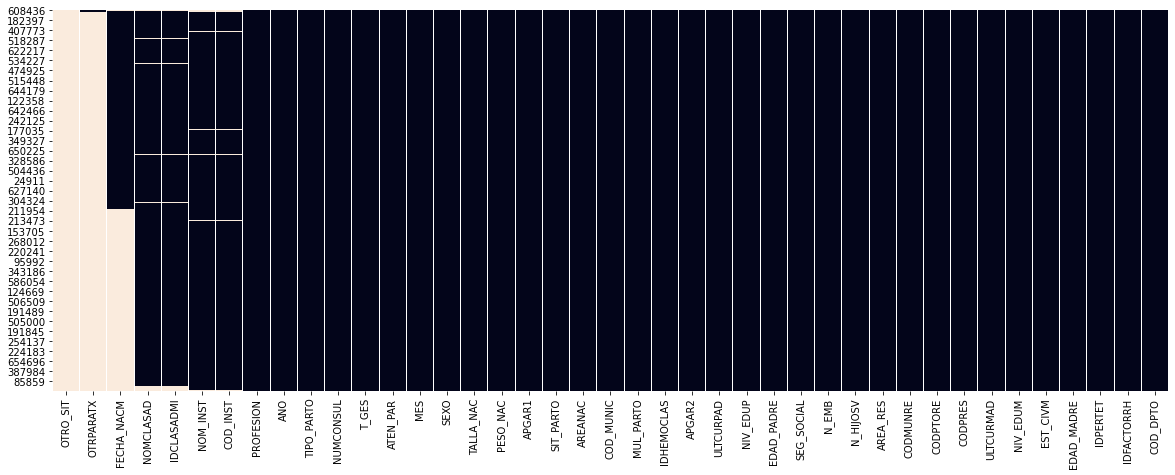

In [15]:
col_order_null=nac_2017.isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(nac_2017[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [17]:
non_num=['NOM_INST','NOMCLASAD','OCUPACION','OTRSITIODE','IDCLASADMI','C_MUERTEC', 'C_MUERTED', 'C_MUERTEE','C_DIR1', 'C_DIR12',
       'C_ANT1', 'C_ANT12', 'C_ANT2', 'C_ANT22', 'C_ANT3', 'C_ANT32', 'C_PAT1',
       'C_PAT2', 'C_BAS1', 'C_MCM1','COD_INST']
nofet_2017=emptytonull(nofet_2017)
nofet_2017[list(set(nofet_2017)-set(non_num))]=nofet_2017[list(set(nofet_2017)-set(non_num))].astype(float)
#nac_2017
nofet_2017.columns

Index(['COD_DPTO', 'COD_MUNIC', 'A_DEFUN', 'SIT_DEFUN', 'OTRSITIODE',
       'COD_INST', 'NOM_INST', 'TIPO_DEFUN', 'ANO', 'MES', 'HORA', 'MINUTOS',
       'SEXO', 'GRU_ED1', 'IDPERTET', 'CODPRES', 'CODPTORE', 'CODMUNRE',
       'AREA_RES', 'SEG_SOCIAL', 'IDADMISALU', 'IDCLASADMI', 'PMAN_MUER',
       'CONS_EXP', 'MU_PARTO', 'T_PARTO', 'TIPO_EMB', 'T_GES', 'PESO_NAC',
       'EDAD_MADRE', 'N_HIJOSV', 'N_HIJOSM', 'EST_CIVM', 'NIV_EDUM',
       'ULTCURMAD', 'MAN_MUER', 'CODOCUR', 'CODMUNOC', 'C_MUERTE', 'C_MUERTEB',
       'C_MUERTEC', 'C_MUERTED', 'C_MUERTEE', 'ASIS_MED', 'C_DIR1', 'C_DIR12',
       'C_ANT1', 'C_ANT12', 'C_ANT2', 'C_ANT22', 'C_ANT3', 'C_ANT32', 'C_PAT1',
       'C_PAT2', 'C_BAS1', 'C_MCM1', 'CAUSA_666', 'IDPROFCER', 'CAU_HOMOL'],
      dtype='object')

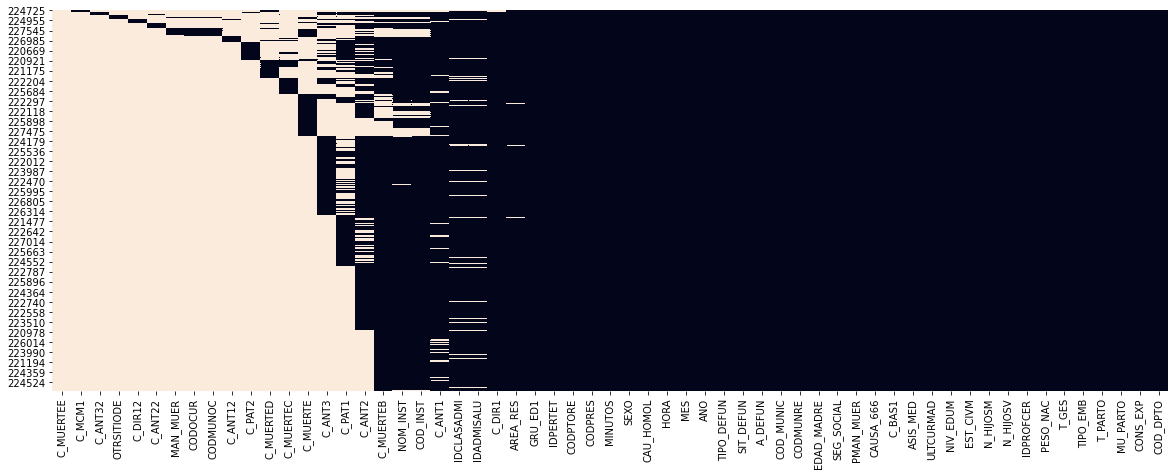

In [18]:
col_order_null=nofet_2017.isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(nofet_2017[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

Algunas de estas columnas identifican muertes violentas, ¿se deberían ignorar estas muertes?

## Verificar "9's" y quitar más columnas

In [21]:
nac_2017_null=max9tonull(nac_2017)

yes COD_DPTO
yes COD_MUNIC
yes AREANAC
yes SIT_PARTO
no NOM_INST
yes COD_INST
yes SEXO
yes PESO_NAC
yes TALLA_NAC
yes ANO
yes MES
yes ATEN_PAR
yes T_GES
yes NUMCONSUL
yes TIPO_PARTO
yes MUL_PARTO
yes APGAR1
yes APGAR2
yes IDHEMOCLAS
yes IDFACTORRH
yes IDPERTET
yes EDAD_MADRE
yes EST_CIVM
yes NIV_EDUM
yes ULTCURMAD
yes CODPRES
yes CODPTORE
yes CODMUNRE
yes AREA_RES
yes N_HIJOSV
no FECHA_NACM
yes N_EMB
yes SEG_SOCIAL
yes IDCLASADMI
no NOMCLASAD
yes EDAD_PADRE
yes NIV_EDUP
yes ULTCURPAD
yes PROFESION


In [22]:
print(nac_2017.shape,'/',nac_2017_null.shape)

(656704, 39) / (656704, 39)


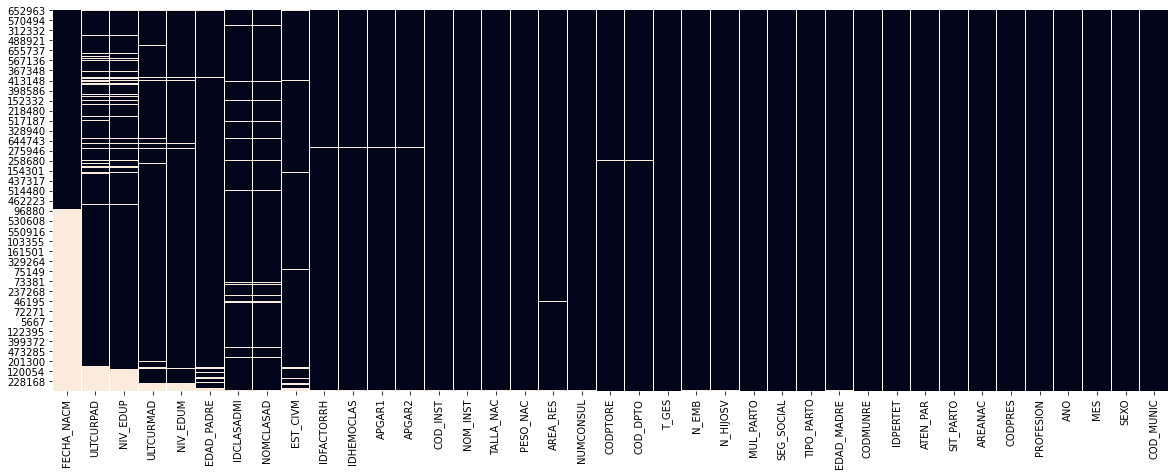

In [23]:
col_order_null=nac_2017_null.isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(nac_2017_null[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [24]:
nofet_2017_null=max9tonull(nofet_2017)

yes COD_DPTO
yes COD_MUNIC
yes A_DEFUN
yes SIT_DEFUN
no COD_INST
no NOM_INST
yes TIPO_DEFUN
yes ANO
yes MES
yes HORA
yes MINUTOS
yes SEXO
yes GRU_ED1
yes IDPERTET
yes CODPRES
yes CODPTORE
yes CODMUNRE
yes AREA_RES
yes SEG_SOCIAL
yes IDADMISALU
no IDCLASADMI
yes PMAN_MUER
yes CONS_EXP
yes MU_PARTO
yes T_PARTO
yes TIPO_EMB
yes T_GES
yes PESO_NAC
yes EDAD_MADRE
yes N_HIJOSV
yes N_HIJOSM
yes EST_CIVM
yes NIV_EDUM
yes ULTCURMAD
yes C_MUERTE
yes C_MUERTEB
yes ASIS_MED
no C_DIR1
no C_ANT1
no C_ANT2
no C_ANT3
no C_PAT1
yes C_BAS1
yes CAUSA_666
yes IDPROFCER
yes CAU_HOMOL


In [25]:
print(nofet_2017.shape,'/',nofet_2017_null.shape)

(7044, 46) / (7044, 46)


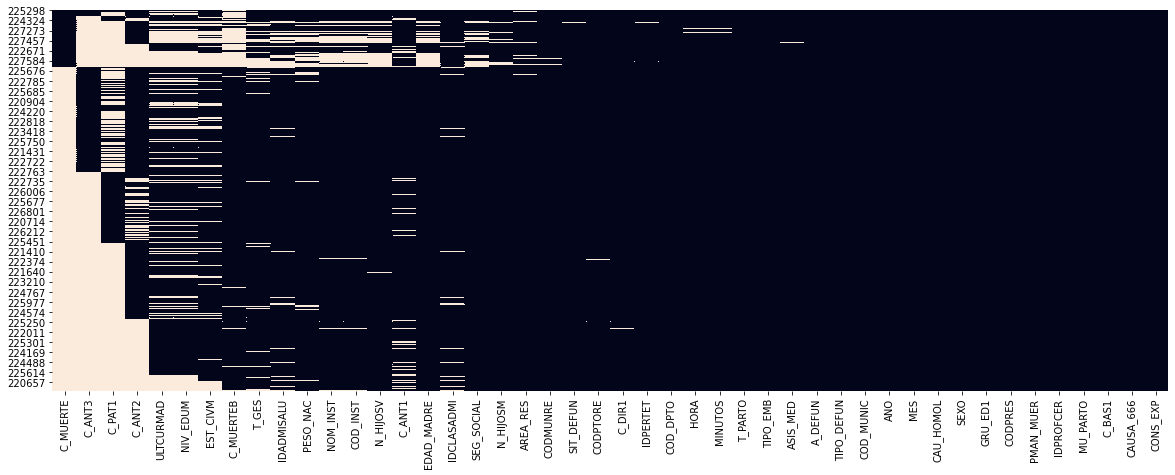

In [26]:
col_order_null=nofet_2017_null.isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(nofet_2017_null[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

-------------------------------

## Match tomando sólo las variables que entran al modelo

In [27]:
nofet_2017['GRU_ED1'].value_counts().sort_index()/len(nofet_2017['GRU_ED1'])

0.0    0.045287
1.0    0.151334
2.0    0.245315
3.0    0.200880
4.0    0.006814
5.0    0.251136
6.0    0.099233
Name: GRU_ED1, dtype: float64

In [28]:
nac=nac_2017.fillna('')
nfet=nofet_2017.fillna('')
nfet.rename(columns={'T_PARTO':'TIPO_PARTO','TIPO_EMB':'MUL_PARTO'},inplace=True)

In [29]:
nac['F_ID']='NAC'+'_'+nac.index.astype('str')
nfet['F_ID']='NFET'+'_'+nfet.index.astype('str')
nac['DS_ORIG']=1
nfet['DS_ORIG']=3

In [30]:
df=pd.concat([nac,nfet], join='inner')

In [31]:
pd.set_option('display.max_columns', None)
df

,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG
0,76.0,1.0,E.S.E. HOSPITAL UNIVERSITARIO DEL VALLE EVARIS...,7.6001e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,5.0,3.0,6.0,170.0,76.0,1.0,1,1.0,2.0,2,NAC_0,1
1,8.0,1.0,IPS HEROSAN LTDA- CLINICA SAN JOAQUIN,8.00101e+10,1.0,5.0,2017.0,1.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,170.0,13.0,140.0,1,1.0,2.0,2,NAC_1,1
2,5.0,154.0,E.S.E. HOSPITAL CESAR URIBE PIEDRAHITA,5.15402e+10,2.0,6.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,8.0,170.0,5.0,154.0,1,1.0,2.0,2,NAC_2,1
3,23.0,1.0,CASA DEL NI?O LTDA.,2.3001e+11,2.0,5.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,7.0,170.0,23.0,807.0,3,1.0,2.0,2,NAC_3,1
4,23.0,162.0,EMPRESA SOCIAL DEL ESTADO HOSPITAL SANDIEGO DE...,2.3162e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,3.0,9.0,170.0,23.0,300.0,2,1.0,2.0,2,NAC_4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227619,18.0,753.0,,,2.0,9.0,2017.0,11.0,1.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,18.0,753.0,3,99.0,2.0,ASMET SALUD ESS - ASOCIACION MUTUAL LA ESPERANZA,NFET_227619,3
227620,11.0,1.0,,,2.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11.0,1.0,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227620,3
227621,25.0,754.0,,,1.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,25.0,754.0,1,99.0,9.0,SIN INFORMACION,NFET_227621,3
227622,11.0,1.0,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11.0,1.0,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227622,3


In [32]:
df.columns

Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG'],
      dtype='object')

In [33]:
df.dtypes

COD_DPTO      float64
COD_MUNIC     float64
NOM_INST       object
COD_INST       object
SEXO          float64
PESO_NAC      float64
ANO           float64
MES           float64
T_GES         float64
TIPO_PARTO    float64
MUL_PARTO     float64
IDPERTET      float64
EDAD_MADRE    float64
EST_CIVM      float64
NIV_EDUM      float64
ULTCURMAD     float64
CODPRES       float64
CODPTORE      float64
CODMUNRE      float64
AREA_RES       object
N_HIJOSV      float64
SEG_SOCIAL    float64
IDCLASADMI     object
F_ID           object
DS_ORIG         int64
dtype: object

In [34]:
df_null=max9tonull(df)
df_null=emptytonull(df)

yes COD_DPTO
yes COD_MUNIC
yes NOM_INST
no COD_INST
yes SEXO
yes PESO_NAC
yes ANO
yes MES
yes T_GES
yes TIPO_PARTO
yes MUL_PARTO
yes IDPERTET
yes EDAD_MADRE
yes EST_CIVM
yes NIV_EDUM
yes ULTCURMAD
yes CODPRES
yes CODPTORE
yes CODMUNRE
no AREA_RES
yes N_HIJOSV
yes SEG_SOCIAL
no IDCLASADMI
yes F_ID
yes DS_ORIG


In [35]:
col_order_null=df.isnull().sum().sort_values(ascending=False).index.tolist()

In [36]:
print(df.columns)
print(df_null.columns)

Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG'],
      dtype='object')
Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG'],
      dtype='object')


### Verificar Datos Faltantes

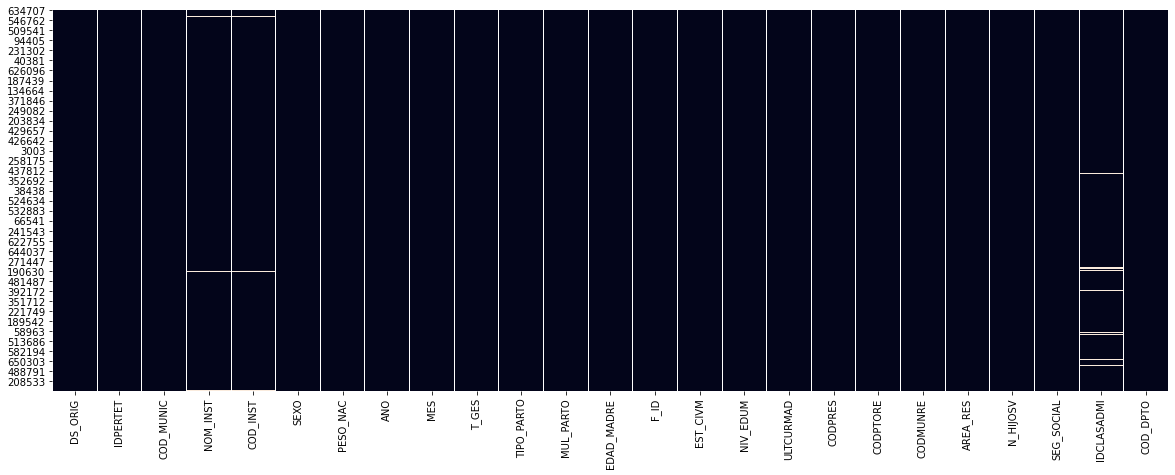

In [37]:
fig = plt.figure(figsize=(20,7))
sns.heatmap(df_null[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [38]:
print(df_null.shape)
print(df_null.dropna().shape)
print(df_null.dropna().shape[0]/df_null.shape[0])

(663748, 25)
(641926, 25)
0.9671230647775964


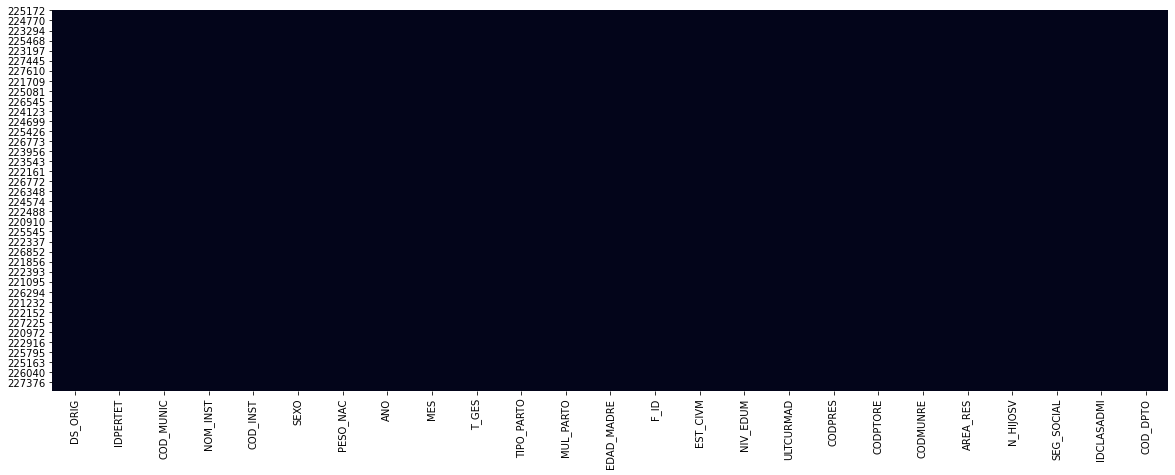

In [39]:
fig = plt.figure(figsize=(20,7))
sns.heatmap(df.loc[df['DS_ORIG']==3][col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [40]:
print(df_null.loc[df_null['DS_ORIG']==3].shape)
print(df_null.loc[df_null['DS_ORIG']==3].dropna().shape)
print(df_null.loc[df_null['DS_ORIG']==3].dropna().shape[0]/df_null.loc[df_null['DS_ORIG']==3].shape[0])

(7044, 25)
(6133, 25)
0.8706700738216923


### Latitud y Longitud para los municipios

In [41]:
lat_long= pd.read_csv('../Data/GeoData/DANE_Cabeceras_municipales_y_Centros_poblados_Col.csv',sep=';')

In [42]:
lat_long[-5:]

,codigo_departamento,codigo_dpto_mpio,codigo_centro_poblado,nombre_departamento,nombre_municipio,nombre_centro_poblado,nombre_tipo_ctro_pbdo,longitud,latitud,nombre_distrito,tipo_municipio,nombre_area_metro
7879,99,99773,99773021,VICHADA,CUMARIBO,EL TUPARRO,CENTRO POBLADO,-68.276000,5.128000,NaN,MUNICIPIO,NaN
7880,99,99773,99773024,VICHADA,CUMARIBO,BRISA,CENTRO POBLADO,-69.773596,4.343518,NaN,MUNICIPIO,NaN
7881,99,99773,99773025,VICHADA,CUMARIBO,GUATURIBA,CENTRO POBLADO,-69.854645,4.345130,NaN,MUNICIPIO,NaN
7882,99,99773,99773026,VICHADA,CUMARIBO,MATSULDANI,CENTRO POBLADO,-69.797888,4.342496,NaN,MUNICIPIO,NaN
7883,99,99773,99773027,VICHADA,CUMARIBO,REMANSO,CENTRO POBLADO,-69.852692,4.333819,NaN,MUNICIPIO,NaN


In [43]:
lat_long[['longitud','latitud','codigo_dpto_mpio','codigo_departamento']].describe()

,longitud,latitud,codigo_dpto_mpio,codigo_departamento
count,7865.000000,7865.000000,7884.000000,7884.000000
mean,-75.129494,5.837281,40708.765221,40.300863
std,1.664400,2.945843,26029.627118,26.052237
min,-81.730001,-4.199837,5001.000000,5.000000
25%,-76.253906,3.719879,19130.000000,19.000000
50%,-75.342317,5.611415,27745.000000,27.000000
75%,-74.038597,8.470075,68092.000000,68.000000
max,-66.963739,13.383969,99773.000000,99.000000


In [44]:
print(lat_long.nunique())
print(len(lat_long))

codigo_departamento        33
codigo_dpto_mpio         1121
codigo_centro_poblado    7884
nombre_departamento        33
nombre_municipio         1038
nombre_centro_poblado    5469
nombre_tipo_ctro_pbdo       2
longitud                 7776
latitud                  7777
nombre_distrito             9
tipo_municipio              3
nombre_area_metro           6
dtype: int64
7884


In [45]:
lat_long_munic=pd.DataFrame(lat_long.groupby(['codigo_departamento','codigo_dpto_mpio','nombre_departamento',
                                 'nombre_municipio']).mean()[['longitud','latitud']].to_records())

In [46]:
lat_long_munic[['codigo_dpto_mpio','codigo_departamento']]=lat_long_munic[['codigo_dpto_mpio','codigo_departamento']].astype(str)

temp=df.copy()
print(len(temp))

temp[['COD_DPTO','COD_MUNIC']]=temp[['COD_DPTO','COD_MUNIC']].astype(int).astype(str)
temp['COD_MUNIC']=temp['COD_MUNIC'].apply(lambda x: '{0:0>3}'.format(x))
temp['DPTO_MUNIC']=temp[['COD_DPTO','COD_MUNIC']].apply(''.join, axis=1)

left=temp
right=lat_long_munic
df_coor=pd.merge(left,right,left_on='DPTO_MUNIC',right_on='codigo_dpto_mpio', how='left',indicator=True)
df_coor

663748


,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,_merge
0,76,001,E.S.E. HOSPITAL UNIVERSITARIO DEL VALLE EVARIS...,7.6001e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,5.0,3.0,6.0,170.0,76.0,1.0,1,1.0,2.0,2,NAC_0,1,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,both
1,8,001,IPS HEROSAN LTDA- CLINICA SAN JOAQUIN,8.00101e+10,1.0,5.0,2017.0,1.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,170.0,13.0,140.0,1,1.0,2.0,2,NAC_1,1,8001,8,8001,ATLANTICO,BARRANQUILLA,-74.795259,10.975927,both
2,5,154,E.S.E. HOSPITAL CESAR URIBE PIEDRAHITA,5.15402e+10,2.0,6.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,8.0,170.0,5.0,154.0,1,1.0,2.0,2,NAC_2,1,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,both
3,23,001,CASA DEL NI?O LTDA.,2.3001e+11,2.0,5.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,7.0,170.0,23.0,807.0,3,1.0,2.0,2,NAC_3,1,23001,23,23001,CORDOBA,MONTERIA,-75.944683,8.616615,both
4,23,162,EMPRESA SOCIAL DEL ESTADO HOSPITAL SANDIEGO DE...,2.3162e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,3.0,9.0,170.0,23.0,300.0,2,1.0,2.0,2,NAC_4,1,23162,23,23162,CORDOBA,CERETE,-75.809719,8.900267,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663743,18,753,,,2.0,9.0,2017.0,11.0,1.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,18.0,753.0,3,99.0,2.0,ASMET SALUD ESS - ASOCIACION MUTUAL LA ESPERANZA,NFET_227619,3,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,both
663744,11,001,,,2.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11.0,1.0,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227620,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,both
663745,25,754,,,1.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,25.0,754.0,1,99.0,9.0,SIN INFORMACION,NFET_227621,3,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,both
663746,11,001,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11.0,1.0,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227622,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,both


In [47]:
df_coor[df_coor['_merge']=='left_only']

,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,_merge
360203,94,663,,,2.0,6.0,2017.0,3.0,3.0,1.0,1.0,1.0,4.0,1.0,2.0,4.0,170.0,94.0,663.0,3,6.0,2.0,2,NAC_360203,1,94663,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [48]:
df_coor.columns

Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG', 'DPTO_MUNIC', 'codigo_departamento',
       'codigo_dpto_mpio', 'nombre_departamento', 'nombre_municipio',
       'longitud', 'latitud', '_merge'],
      dtype='object')

In [49]:
len(df)

663748

In [50]:
temp=df_coor.drop(columns='_merge')
print(len(temp))
temp[['CODPTORE','CODMUNRE']]=temp[['CODPTORE','CODMUNRE']].astype(int).astype(str)
temp['CODMUNRE']=temp['CODMUNRE'].apply(lambda x: '{0:0>3}'.format(x))
temp['DPTO_MUNIC_RE']=temp[['CODPTORE','CODMUNRE']].apply(''.join, axis=1)

left=temp
right=lat_long_munic
df_coor_re=pd.merge(left,right,left_on='DPTO_MUNIC_RE',right_on='codigo_dpto_mpio', 
                            suffixes=('','_re'), how='left', indicator=True)
print(len(df_coor_re))
df_coor_re

663748
663748


,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,DPTO_MUNIC_RE,codigo_departamento_re,codigo_dpto_mpio_re,nombre_departamento_re,nombre_municipio_re,longitud_re,latitud_re,_merge
0,76,001,E.S.E. HOSPITAL UNIVERSITARIO DEL VALLE EVARIS...,7.6001e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,5.0,3.0,6.0,170.0,76,001,1,1.0,2.0,2,NAC_0,1,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,both
1,8,001,IPS HEROSAN LTDA- CLINICA SAN JOAQUIN,8.00101e+10,1.0,5.0,2017.0,1.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,170.0,13,140,1,1.0,2.0,2,NAC_1,1,8001,8,8001,ATLANTICO,BARRANQUILLA,-74.795259,10.975927,13140,13,13140,BOLIVAR,CALAMAR,-74.970124,10.199810,both
2,5,154,E.S.E. HOSPITAL CESAR URIBE PIEDRAHITA,5.15402e+10,2.0,6.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,8.0,170.0,5,154,1,1.0,2.0,2,NAC_2,1,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,both
3,23,001,CASA DEL NI?O LTDA.,2.3001e+11,2.0,5.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,7.0,170.0,23,807,3,1.0,2.0,2,NAC_3,1,23001,23,23001,CORDOBA,MONTERIA,-75.944683,8.616615,23807,23,23807,CORDOBA,TIERRALTA,-76.048942,8.126264,both
4,23,162,EMPRESA SOCIAL DEL ESTADO HOSPITAL SANDIEGO DE...,2.3162e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,3.0,9.0,170.0,23,300,2,1.0,2.0,2,NAC_4,1,23162,23,23162,CORDOBA,CERETE,-75.809719,8.900267,23300,23,23300,CORDOBA,COTORRA,-75.785258,9.047266,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663743,18,753,,,2.0,9.0,2017.0,11.0,1.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,18,753,3,99.0,2.0,ASMET SALUD ESS - ASOCIACION MUTUAL LA ESPERANZA,NFET_227619,3,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,both
663744,11,001,,,2.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227620,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,both
663745,25,754,,,1.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,25,754,1,99.0,9.0,SIN INFORMACION,NFET_227621,3,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,both
663746,11,001,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227622,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,both


In [51]:
df_coor_re['_merge'].value_counts()

both          662399
left_only       1349
right_only         0
Name: _merge, dtype: int64

In [52]:
df_coor_re[df_coor_re['_merge']=='left_only']

,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,DPTO_MUNIC_RE,codigo_departamento_re,codigo_dpto_mpio_re,nombre_departamento_re,nombre_municipio_re,longitud_re,latitud_re,_merge
181,99,001,E.S.E. HOSPITAL DEPARTAMENTAL SAN JUAN DE DIOS,9.9001e+11,1.0,5.0,2017.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,13.0,99.0,862.0,75,862,9,1.0,5.0,,NAC_181,1,99001,99,99001,VICHADA,PUERTO CARRENO,-68.037721,5.993723,75862,NaN,NaN,NaN,NaN,NaN,NaN,left_only
656,13,001,EMPRESA SOCIAL DEL ESTADO CLINICA MATERNIDAD R...,1.3001e+11,2.0,5.0,2017.0,2.0,3.0,1.0,1.0,6.0,1.0,5.0,3.0,8.0,862.0,75,862,9,1.0,5.0,,NAC_656,1,13001,13,13001,BOLIVAR,CARTAGENA DE INDIAS,-75.544232,10.351322,75862,NaN,NaN,NaN,NaN,NaN,NaN,left_only
913,13,001,EMPRESA SOCIAL DEL ESTADO CLINICA MATERNIDAD R...,1.3001e+11,1.0,3.0,2017.0,2.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,862.0,75,862,9,1.0,5.0,,NAC_913,1,13001,13,13001,BOLIVAR,CARTAGENA DE INDIAS,-75.544232,10.351322,75862,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1146,54,001,E.S.E HOSPITAL UNIVERSITARIO ERASMO MEOZ,5.4001e+11,1.0,4.0,2017.0,5.0,3.0,1.0,1.0,6.0,1.0,9.0,99.0,99.0,862.0,75,862,9,1.0,5.0,,NAC_1146,1,54001,54,54001,NORTE DE SANTANDER,CUCUTA,-72.464566,8.139360,75862,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2676,13,001,EMPRESA SOCIAL DEL ESTADO CLINICA MATERNIDAD R...,1.3001e+11,2.0,7.0,2017.0,6.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,9.0,862.0,75,862,9,1.0,5.0,,NAC_2676,1,13001,13,13001,BOLIVAR,CARTAGENA DE INDIAS,-75.544232,10.351322,75862,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663685,25,817,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,1,999,9,99.0,2.0,E.P.S. FAMISANAR LTDA.-CM,NFET_227561,3,25817,25,25817,CUNDINAMARCA,TOCANCIPA,-73.930400,4.958395,1999,NaN,NaN,NaN,NaN,NaN,NaN,left_only
663695,68,190,,,2.0,9.0,2017.0,1.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,1,999,9,99.0,9.0,SIN INFORMACION,NFET_227571,3,68190,68,68190,SANTANDER,CIMITARRA,-74.214510,6.378340,1999,NaN,NaN,NaN,NaN,NaN,NaN,left_only
663696,25,785,,,1.0,9.0,2017.0,1.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,1,999,9,99.0,1.0,FAMISANAR LTDA. E.P.S.,NFET_227572,3,25785,25,25785,CUNDINAMARCA,TABIO,-74.091709,4.924216,1999,NaN,NaN,NaN,NaN,NaN,NaN,left_only
663700,11,001,,,2.0,9.0,2017.0,8.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,1,999,9,99.0,9.0,SIN INFORMACION,NFET_227576,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,1999,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [53]:
df_coor_re.groupby(['_merge','CODPRES']).size()

_merge     CODPRES
left_only  44.0         1
           76.0        24
           124.0        1
           152.0        1
           170.0      124
                     ... 
both       780.0        0
           840.0        0
           862.0        0
           891.0        0
           999.0        0
Length: 84, dtype: int64

In [54]:
df_coor_re.groupby(['_merge','DS_ORIG']).size()

_merge      DS_ORIG
left_only   1            1271
            3              78
right_only  1               0
            3               0
both        1          655433
            3            6966
dtype: int64

In [55]:
df_coor_re.columns

Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG', 'DPTO_MUNIC', 'codigo_departamento',
       'codigo_dpto_mpio', 'nombre_departamento', 'nombre_municipio',
       'longitud', 'latitud', 'DPTO_MUNIC_RE', 'codigo_departamento_re',
       'codigo_dpto_mpio_re', 'nombre_departamento_re', 'nombre_municipio_re',
       'longitud_re', 'latitud_re', '_merge'],
      dtype='object')

### Region

In [56]:
region= pd.read_csv('../Data/GeoData/Departamentos_y_municipios_de_Colombia.csv',sep=',')

In [57]:
region[:5]

,REGION,CÓDIGO DANE DEL DEPARTAMENTO,DEPARTAMENTO,CÓDIGO DANE DEL MUNICIPIO,MUNICIPIO
0,Región Eje Cafetero - Antioquia,5,Antioquia,5001,Medellín
1,Región Eje Cafetero - Antioquia,5,Antioquia,5002,Abejorral
2,Región Eje Cafetero - Antioquia,5,Antioquia,5004,Abriaquí
3,Región Eje Cafetero - Antioquia,5,Antioquia,5021,Alejandría
4,Región Eje Cafetero - Antioquia,5,Antioquia,5030,Amagá


In [58]:
region.columns

Index(['REGION', 'CÓDIGO DANE DEL DEPARTAMENTO', 'DEPARTAMENTO',
       'CÓDIGO DANE DEL MUNICIPIO', 'MUNICIPIO'],
      dtype='object')

In [59]:
region.rename(columns={'CÓDIGO DANE DEL DEPARTAMENTO':'COD_DPTO'},inplace=True)

In [60]:
region=region[['REGION','COD_DPTO']].drop_duplicates().astype(str)

In [61]:
region.shape

(33, 2)

In [62]:
df_coor_re.dtypes

COD_DPTO                    object
COD_MUNIC                   object
NOM_INST                    object
COD_INST                    object
SEXO                       float64
PESO_NAC                   float64
ANO                        float64
MES                        float64
T_GES                      float64
TIPO_PARTO                 float64
MUL_PARTO                  float64
IDPERTET                   float64
EDAD_MADRE                 float64
EST_CIVM                   float64
NIV_EDUM                   float64
ULTCURMAD                  float64
CODPRES                    float64
CODPTORE                    object
CODMUNRE                    object
AREA_RES                    object
N_HIJOSV                   float64
SEG_SOCIAL                 float64
IDCLASADMI                  object
F_ID                        object
DS_ORIG                      int64
DPTO_MUNIC                  object
codigo_departamento         object
codigo_dpto_mpio            object
nombre_departamento 

In [63]:
left=df_coor_re.drop(columns='_merge')
print(len(left))

right=region

df_region=pd.merge(left,right,on='COD_DPTO',
                            how='left',indicator=True)#, indicator=True)
print(len(df_region))
df_region

663748
663748


,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,DPTO_MUNIC_RE,codigo_departamento_re,codigo_dpto_mpio_re,nombre_departamento_re,nombre_municipio_re,longitud_re,latitud_re,REGION,_merge
0,76,001,E.S.E. HOSPITAL UNIVERSITARIO DEL VALLE EVARIS...,7.6001e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,5.0,3.0,6.0,170.0,76,001,1,1.0,2.0,2,NAC_0,1,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,Región Pacífico,both
1,8,001,IPS HEROSAN LTDA- CLINICA SAN JOAQUIN,8.00101e+10,1.0,5.0,2017.0,1.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,170.0,13,140,1,1.0,2.0,2,NAC_1,1,8001,8,8001,ATLANTICO,BARRANQUILLA,-74.795259,10.975927,13140,13,13140,BOLIVAR,CALAMAR,-74.970124,10.199810,Región Caribe,both
2,5,154,E.S.E. HOSPITAL CESAR URIBE PIEDRAHITA,5.15402e+10,2.0,6.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,8.0,170.0,5,154,1,1.0,2.0,2,NAC_2,1,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,Región Eje Cafetero - Antioquia,both
3,23,001,CASA DEL NI?O LTDA.,2.3001e+11,2.0,5.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,7.0,170.0,23,807,3,1.0,2.0,2,NAC_3,1,23001,23,23001,CORDOBA,MONTERIA,-75.944683,8.616615,23807,23,23807,CORDOBA,TIERRALTA,-76.048942,8.126264,Región Caribe,both
4,23,162,EMPRESA SOCIAL DEL ESTADO HOSPITAL SANDIEGO DE...,2.3162e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,3.0,9.0,170.0,23,300,2,1.0,2.0,2,NAC_4,1,23162,23,23162,CORDOBA,CERETE,-75.809719,8.900267,23300,23,23300,CORDOBA,COTORRA,-75.785258,9.047266,Región Caribe,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663743,18,753,,,2.0,9.0,2017.0,11.0,1.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,18,753,3,99.0,2.0,ASMET SALUD ESS - ASOCIACION MUTUAL LA ESPERANZA,NFET_227619,3,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,Región Centro Sur,both
663744,11,001,,,2.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227620,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,Región Centro Oriente,both
663745,25,754,,,1.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,25,754,1,99.0,9.0,SIN INFORMACION,NFET_227621,3,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,Región Centro Oriente,both
663746,11,001,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227622,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,Región Centro Oriente,both


In [64]:
df_region['_merge'].value_counts()

both          663748
right_only         0
left_only          0
Name: _merge, dtype: int64

In [65]:
left=df_region.drop(columns='_merge')
print(len(left))

right=region

df_region_re=pd.merge(left,right,left_on='CODPTORE',right_on='COD_DPTO', 
                            suffixes=('','_re'), how='left',indicator=True)#, indicator=True)
print(len(df_region_re))
df_region_re

663748
663748


,COD_DPTO,COD_MUNIC,NOM_INST,COD_INST,SEXO,PESO_NAC,ANO,MES,T_GES,TIPO_PARTO,MUL_PARTO,IDPERTET,EDAD_MADRE,EST_CIVM,NIV_EDUM,ULTCURMAD,CODPRES,CODPTORE,CODMUNRE,AREA_RES,N_HIJOSV,SEG_SOCIAL,IDCLASADMI,F_ID,DS_ORIG,DPTO_MUNIC,codigo_departamento,codigo_dpto_mpio,nombre_departamento,nombre_municipio,longitud,latitud,DPTO_MUNIC_RE,codigo_departamento_re,codigo_dpto_mpio_re,nombre_departamento_re,nombre_municipio_re,longitud_re,latitud_re,REGION,REGION_re,COD_DPTO_re,_merge
0,76,001,E.S.E. HOSPITAL UNIVERSITARIO DEL VALLE EVARIS...,7.6001e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,5.0,3.0,6.0,170.0,76,001,1,1.0,2.0,2,NAC_0,1,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,76001,76,76001,VALLE DEL CAUCA,CALI,-76.561400,3.406996,Región Pacífico,Región Pacífico,76,both
1,8,001,IPS HEROSAN LTDA- CLINICA SAN JOAQUIN,8.00101e+10,1.0,5.0,2017.0,1.0,3.0,1.0,1.0,6.0,1.0,2.0,2.0,5.0,170.0,13,140,1,1.0,2.0,2,NAC_1,1,8001,8,8001,ATLANTICO,BARRANQUILLA,-74.795259,10.975927,13140,13,13140,BOLIVAR,CALAMAR,-74.970124,10.199810,Región Caribe,Región Caribe,13,both
2,5,154,E.S.E. HOSPITAL CESAR URIBE PIEDRAHITA,5.15402e+10,2.0,6.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,8.0,170.0,5,154,1,1.0,2.0,2,NAC_2,1,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,5154,5,5154,ANTIOQUIA,CAUCASIA,-75.053494,7.940203,Región Eje Cafetero - Antioquia,Región Eje Cafetero - Antioquia,5,both
3,23,001,CASA DEL NI?O LTDA.,2.3001e+11,2.0,5.0,2017.0,1.0,4.0,2.0,1.0,6.0,1.0,2.0,3.0,7.0,170.0,23,807,3,1.0,2.0,2,NAC_3,1,23001,23,23001,CORDOBA,MONTERIA,-75.944683,8.616615,23807,23,23807,CORDOBA,TIERRALTA,-76.048942,8.126264,Región Caribe,Región Caribe,23,both
4,23,162,EMPRESA SOCIAL DEL ESTADO HOSPITAL SANDIEGO DE...,2.3162e+11,1.0,6.0,2017.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,3.0,9.0,170.0,23,300,2,1.0,2.0,2,NAC_4,1,23162,23,23162,CORDOBA,CERETE,-75.809719,8.900267,23300,23,23300,CORDOBA,COTORRA,-75.785258,9.047266,Región Caribe,Región Caribe,23,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663743,18,753,,,2.0,9.0,2017.0,11.0,1.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,18,753,3,99.0,2.0,ASMET SALUD ESS - ASOCIACION MUTUAL LA ESPERANZA,NFET_227619,3,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,18753,18,18753,CAQUETA,SAN VICENTE DEL CAGUAN,-74.809059,2.214064,Región Centro Sur,Región Centro Sur,18,both
663744,11,001,,,2.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227620,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,Región Centro Oriente,Región Centro Oriente,11,both
663745,25,754,,,1.0,9.0,2017.0,3.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,25,754,1,99.0,9.0,SIN INFORMACION,NFET_227621,3,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,25754,25,25754,CUNDINAMARCA,SOACHA,-74.238384,4.552672,Región Centro Oriente,Región Centro Oriente,25,both
663746,11,001,,,1.0,9.0,2017.0,7.0,9.0,4.0,1.0,6.0,99.0,9.0,99.0,99.0,170.0,11,001,1,99.0,1.0,COMPENSAR E.P.S.,NFET_227622,3,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,11001,11,11001,"BOGOTA, D. C.","BOGOTA, D.C.",-74.206054,4.316840,Región Centro Oriente,Región Centro Oriente,11,both


In [66]:
df_region_re['_merge'].value_counts()

both          662404
left_only       1344
right_only         0
Name: _merge, dtype: int64

In [67]:
df_infants=df_region_re.copy()

# "MATCHING"

<Figure size 1440x1080 with 0 Axes>

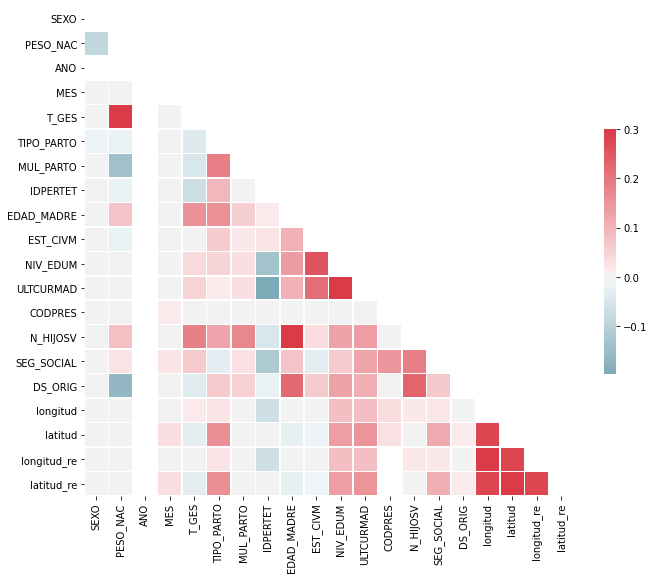

In [68]:
df_plot=df_infants.corr()
fig = plt.figure(figsize=(20,15))
mask = np.zeros_like(df_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
#mask[np.diag_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(df_plot, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
# save to file
fig = sns_plot.get_figure()
fig.savefig('corr')

In [658]:
#Columns to enter the model
df_infants=df_infants.rename(columns={'nombre_departamento_re':'dpto_re'})
num_cols= [ 'T_GES','PESO_NAC']#',,'latitud_re'
cat_cols=['SEXO', 'TIPO_PARTO', 'AREA_RES','dpto_re','SEG_SOCIAL']#,,,'MUL_PARTO'
model_cols=num_cols+cat_cols

<Figure size 720x720 with 0 Axes>

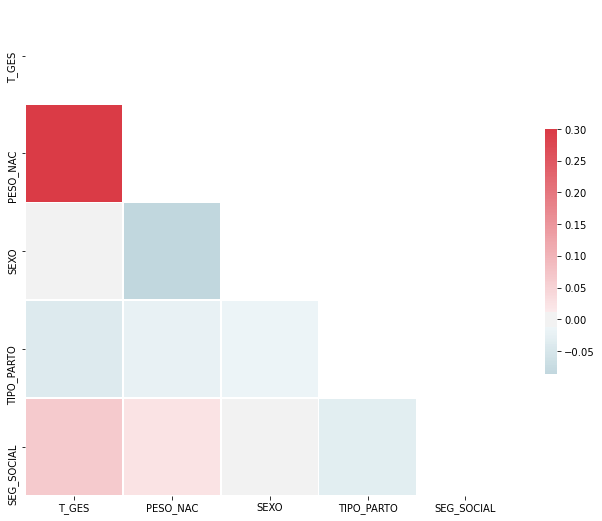

In [659]:
df_plot=df_infants[model_cols].corr()
fig = plt.figure(figsize=(10,10))
mask = np.zeros_like(df_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
#mask[np.diag_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(df_plot, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
# save to file
fig = sns_plot.get_figure()
fig.savefig('corr_model')

## Nuevo Data Frame haciendo matching de las variables que vamos a utilizar en el modelo

In [660]:
df_model=df_infants[model_cols+['F_ID','DS_ORIG']].astype(str)
df_model['ones']=1
df_model

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,F_ID,DS_ORIG,ones
0,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,NAC_0,1,1
1,3.0,5.0,1.0,1.0,1.0,BOLIVAR,2.0,NAC_1,1,1
2,4.0,6.0,2.0,2.0,1.0,ANTIOQUIA,2.0,NAC_2,1,1
3,4.0,5.0,2.0,2.0,3.0,CORDOBA,2.0,NAC_3,1,1
4,4.0,6.0,1.0,1.0,2.0,CORDOBA,2.0,NAC_4,1,1
...,...,...,...,...,...,...,...,...,...,...
663743,1.0,9.0,2.0,4.0,3.0,CAQUETA,2.0,NFET_227619,3,1
663744,9.0,9.0,2.0,4.0,1.0,"BOGOTA, D. C.",1.0,NFET_227620,3,1
663745,9.0,9.0,1.0,4.0,1.0,CUNDINAMARCA,9.0,NFET_227621,3,1
663746,9.0,9.0,1.0,4.0,1.0,"BOGOTA, D. C.",1.0,NFET_227622,3,1


In [661]:
df_model=df_model.sort_values(model_cols+['DS_ORIG']).assign(count=df_model.groupby(model_cols+['DS_ORIG']).cumcount())
df_model

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,F_ID,DS_ORIG,ones,count
422624,1.0,1.0,1.0,1.0,1.0,ANTIOQUIA,3.0,NAC_422624,1,1,0
661022,1.0,1.0,1.0,1.0,1.0,ANTIOQUIA,3.0,NFET_224898,3,1,0
333994,1.0,1.0,1.0,1.0,1.0,ATLANTICO,2.0,NAC_333994,1,1,0
560193,1.0,1.0,1.0,1.0,1.0,BOLIVAR,2.0,NAC_560193,1,1,0
202588,1.0,1.0,1.0,1.0,1.0,CAQUETA,2.0,NAC_202588,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
656670,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656670,1,1,0
656671,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656671,1,1,1
656698,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656698,1,1,2
656700,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656700,1,1,3


In [662]:
df_model_inv=df_model.drop_duplicates(model_cols+['count'],keep='first')
not_matched=df_model_inv.loc[df_model_inv['DS_ORIG']=='3']
df_model.drop_duplicates(model_cols+['count'],inplace=True,keep='last')

In [663]:
df_model

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,F_ID,DS_ORIG,ones,count
661022,1.0,1.0,1.0,1.0,1.0,ANTIOQUIA,3.0,NFET_224898,3,1,0
333994,1.0,1.0,1.0,1.0,1.0,ATLANTICO,2.0,NAC_333994,1,1,0
560193,1.0,1.0,1.0,1.0,1.0,BOLIVAR,2.0,NAC_560193,1,1,0
202588,1.0,1.0,1.0,1.0,1.0,CAQUETA,2.0,NAC_202588,1,1,0
175212,1.0,1.0,1.0,1.0,1.0,CHOCO,2.0,NAC_175212,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
656670,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656670,1,1,0
656671,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656671,1,1,1
656698,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656698,1,1,2
656700,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656700,1,1,3


In [664]:
not_matched

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,F_ID,DS_ORIG,ones,count
657805,1.0,1.0,1.0,1.0,1.0,MAGDALENA,2.0,NFET_221681,3,1,0
661773,1.0,1.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,NFET_225649,3,1,1
661389,1.0,1.0,1.0,2.0,1.0,ATLANTICO,1.0,NFET_225265,3,1,0
660737,1.0,1.0,1.0,2.0,1.0,VALLE DEL CAUCA,2.0,NFET_224613,3,1,0
663516,1.0,1.0,1.0,4.0,1.0,"BOGOTA, D. C.",1.0,NFET_227392,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
663475,9.0,9.0,2.0,9.0,1.0,"BOGOTA, D. C.",9.0,NFET_227351,3,1,0
663250,9.0,9.0,2.0,9.0,1.0,MAGDALENA,2.0,NFET_227126,3,1,0
657017,9.0,9.0,2.0,9.0,2.0,CASANARE,9.0,NFET_220893,3,1,0
657214,9.0,9.0,2.0,9.0,3.0,BOLIVAR,2.0,NFET_221090,3,1,0


In [665]:
df_model['DS_ORIG'].value_counts()

1    651070
3      7044
Name: DS_ORIG, dtype: int64

In [666]:
df_model_inv['DS_ORIG'].value_counts()

1    656704
3      1410
Name: DS_ORIG, dtype: int64

In [667]:
df_model.loc[df_model['DS_ORIG']=='3']['AREA_RES'].value_counts()

1.0    5246
3.0    1261
2.0     452
9.0      56
         29
Name: AREA_RES, dtype: int64

In [668]:
left=df_model
right=not_matched['F_ID']
df_model=pd.merge(left,right,on='F_ID',how='outer',indicator=True)

In [669]:
df_model['_merge'].value_counts()

left_only     656704
both            1410
right_only         0
Name: _merge, dtype: int64

In [670]:
df_model['not_matched']=np.where(df_model['_merge']=='both',1,0)
df_model.drop(columns=['_merge','ones','count'],inplace=True)

In [671]:
df_model

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,F_ID,DS_ORIG,not_matched
0,1.0,1.0,1.0,1.0,1.0,ANTIOQUIA,3.0,NFET_224898,3,0
1,1.0,1.0,1.0,1.0,1.0,ATLANTICO,2.0,NAC_333994,1,0
2,1.0,1.0,1.0,1.0,1.0,BOLIVAR,2.0,NAC_560193,1,0
3,1.0,1.0,1.0,1.0,1.0,CAQUETA,2.0,NAC_202588,1,0
4,1.0,1.0,1.0,1.0,1.0,CHOCO,2.0,NAC_175212,1,0
...,...,...,...,...,...,...,...,...,...,...
658109,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656670,1,0
658110,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656671,1,0
658111,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656698,1,0
658112,9.0,9.0,2.0,9.0,9.0,nan,9.0,NAC_656700,1,0


In [672]:
df_model[num_cols]=df_model[num_cols].astype(float)

In [673]:
df_infants['DS_ORIG'].value_counts()

1    656704
3      7044
Name: DS_ORIG, dtype: int64

In [674]:
left=df_infants[model_cols+['DS_ORIG','F_ID']].loc[df_infants['DS_ORIG']==1].astype(str)
right=df_infants[model_cols+['DS_ORIG','F_ID']].loc[df_infants['DS_ORIG']==3].astype(str)
temp=pd.merge(left,right,on=model_cols,how='outer', indicator=True)
temp

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,DS_ORIG_x,F_ID_x,DS_ORIG_y,F_ID_y,_merge
0,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,1,NAC_0,3,NFET_220802,both
1,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,1,NAC_0,3,NFET_220927,both
2,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,1,NAC_0,3,NFET_221142,both
3,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,1,NAC_0,3,NFET_222104,both
4,4.0,6.0,1.0,1.0,1.0,VALLE DEL CAUCA,2.0,1,NAC_0,3,NFET_222173,both
...,...,...,...,...,...,...,...,...,...,...,...,...
2177160,9.0,9.0,2.0,4.0,3.0,BOYACA,9.0,NaN,NaN,3,NFET_227613,right_only
2177161,9.0,9.0,1.0,4.0,3.0,BOYACA,1.0,NaN,NaN,3,NFET_227614,right_only
2177162,9.0,9.0,2.0,4.0,3.0,META,9.0,NaN,NaN,3,NFET_227618,right_only
2177163,1.0,9.0,2.0,4.0,3.0,CAQUETA,2.0,NaN,NaN,3,NFET_227619,right_only


In [675]:
temp['_merge'].value_counts()

both          1964526
left_only      211321
right_only       1318
Name: _merge, dtype: int64

In [676]:
# code the discrete variable by the specification above
df2=df_model.copy()
df2.set_index('F_ID',inplace=True)
df2['DS_ORIG']=np.where(df2['DS_ORIG']=='1',0,1)#Change DS_ORIG  to be 1 for non fetal and 0 for births

In [677]:
df2['DS_ORIG'].value_counts()

0    651070
1      7044
Name: DS_ORIG, dtype: int64

In [678]:
df2

,T_GES,PESO_NAC,SEXO,TIPO_PARTO,AREA_RES,dpto_re,SEG_SOCIAL,DS_ORIG,not_matched
F_ID,,,,,,,,,
NFET_224898,1.0,1.0,1.0,1.0,1.0,ANTIOQUIA,3.0,1,0
NAC_333994,1.0,1.0,1.0,1.0,1.0,ATLANTICO,2.0,0,0
NAC_560193,1.0,1.0,1.0,1.0,1.0,BOLIVAR,2.0,0,0
NAC_202588,1.0,1.0,1.0,1.0,1.0,CAQUETA,2.0,0,0
NAC_175212,1.0,1.0,1.0,1.0,1.0,CHOCO,2.0,0,0
...,...,...,...,...,...,...,...,...,...
NAC_656670,9.0,9.0,2.0,9.0,9.0,nan,9.0,0,0
NAC_656671,9.0,9.0,2.0,9.0,9.0,nan,9.0,0,0
NAC_656698,9.0,9.0,2.0,9.0,9.0,nan,9.0,0,0


In [679]:
df2['AREA_RES'].value_counts()

1.0    516559
3.0     89670
2.0     50456
9.0      1400
           29
Name: AREA_RES, dtype: int64

In [680]:
df2_null=emptytonull(df2)
df2_null['AREA_RES']=df2_null['AREA_RES'].astype(float)
df2_null=max9tonull(df2_null)

yes T_GES
yes PESO_NAC
yes SEXO
yes TIPO_PARTO
yes AREA_RES
yes dpto_re
yes SEG_SOCIAL
yes DS_ORIG
yes not_matched


In [681]:
print(df2.columns)
print(df2_null.columns)

Index(['T_GES', 'PESO_NAC', 'SEXO', 'TIPO_PARTO', 'AREA_RES', 'dpto_re',
       'SEG_SOCIAL', 'DS_ORIG', 'not_matched'],
      dtype='object')
Index(['T_GES', 'PESO_NAC', 'SEXO', 'TIPO_PARTO', 'AREA_RES', 'dpto_re',
       'SEG_SOCIAL', 'DS_ORIG', 'not_matched'],
      dtype='object')


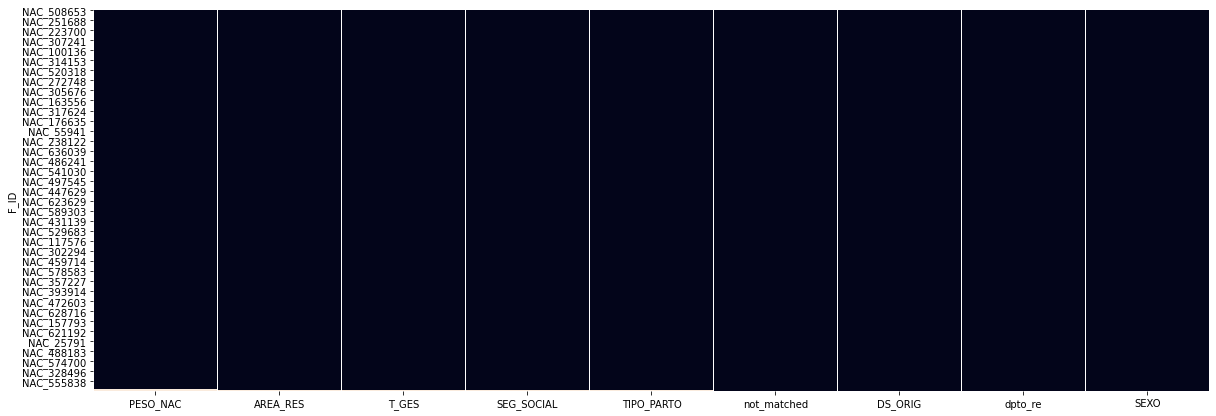

In [682]:
col_order_null=df2_null.isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(df2_null[col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [683]:
print(df2_null.shape)
print(df2_null.dropna().shape)
print(df2_null.dropna().shape[0]/df2_null.shape[0])

(658114, 9)
(653845, 9)
0.9935132818934106


In [684]:
df2['DS_ORIG'].value_counts()

0    651070
1      7044
Name: DS_ORIG, dtype: int64

In [685]:
df2_null['DS_ORIG'].value_counts()

0    651070
1      7044
Name: DS_ORIG, dtype: int64

In [686]:
df2_null['AREA_RES'].value_counts()

1.0    516559
3.0     89670
2.0     50456
Name: AREA_RES, dtype: int64

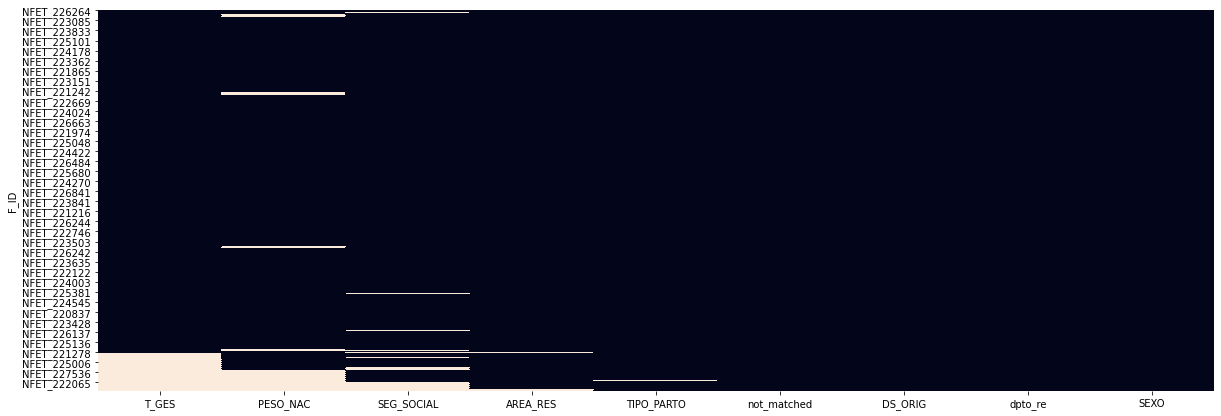

In [687]:
col_order_null=df2_null.loc[df2_null['DS_ORIG']==1].isnull().sum().sort_values(ascending=False).index.tolist()
fig = plt.figure(figsize=(20,7))
sns.heatmap(df2_null.loc[df2_null['DS_ORIG']==1][col_order_null].sort_values(col_order_null).isnull(), cbar=False)

In [688]:
print(df2_null.loc[df2_null['DS_ORIG']==1].shape)
print(df2_null.loc[df2_null['DS_ORIG']==1].dropna().shape)
print(df2_null.loc[df2_null['DS_ORIG']==1].dropna().shape[0]/df2_null.loc[df2_null['DS_ORIG']==1].shape[0])

(7044, 9)
(6055, 9)
0.8595968199886428


In [689]:
df2=df2_null.dropna()

In [690]:
df2['not_matched'].value_counts()

0    653402
1       443
Name: not_matched, dtype: int64

In [691]:
df2['dpto_re'].value_counts()

BOGOTA, D. C.                                               92074
ANTIOQUIA                                                   76753
VALLE DEL CAUCA                                             51642
ATLANTICO                                                   42159
BOLIVAR                                                     36964
CUNDINAMARCA                                                35788
SANTANDER                                                   30059
CORDOBA                                                     26691
MAGDALENA                                                   23490
NORTE DE SANTANDER                                          20842
CESAR                                                       20526
HUILA                                                       19662
CAUCA                                                       18728
NARINO                                                      18154
LA GUAJIRA                                                  17689
TOLIMA    

In [692]:
df2.groupby(['DS_ORIG','SEXO']).size()

DS_ORIG  SEXO
0        1.0     331731
         2.0     315968
         3.0         91
1        1.0       3431
         2.0       2620
         3.0          4
dtype: int64

In [693]:
df2=df2.loc[(df2['SEXO']!='3.0')&(df2['dpto_re']!='nan')]

print(df2['DS_ORIG'].value_counts())
print(df2['not_matched'].value_counts())

0    647695
1      6051
Name: DS_ORIG, dtype: int64
0    653307
1       439
Name: not_matched, dtype: int64


In [694]:
df2.columns

Index(['T_GES', 'PESO_NAC', 'SEXO', 'TIPO_PARTO', 'AREA_RES', 'dpto_re',
       'SEG_SOCIAL', 'DS_ORIG', 'not_matched'],
      dtype='object')

In [695]:
df2['dpto_re'].value_counts().sort_index()

AMAZONAS                                                     1371
ANTIOQUIA                                                   76746
ARAUCA                                                       4424
ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA      859
ATLANTICO                                                   42153
BOGOTA, D. C.                                               92067
BOLIVAR                                                     36945
BOYACA                                                      14709
CALDAS                                                       9290
CAQUETA                                                      7050
CASANARE                                                     6444
CAUCA                                                       18726
CESAR                                                       20524
CHOCO                                                        6086
CORDOBA                                                     26689
CUNDINAMAR

In [696]:
#continuous
df2[num_cols]=(df2[num_cols]-df2[num_cols].mean())/df2[num_cols].std()
#Intercept
df2['Intercept']=1
#categorical
df2.drop(columns='not_matched')
df2['dpto_re']=np.where(df2['dpto_re']=='BOGOTA, D. C.','0_BOGOTA, D. C.',df2['dpto_re'])
df2=pd.get_dummies(df2,columns=cat_cols, drop_first=True)
df2

,T_GES,PESO_NAC,DS_ORIG,not_matched,Intercept,SEXO_2.0,TIPO_PARTO_2.0,TIPO_PARTO_3.0,TIPO_PARTO_4.0,AREA_RES_2.0,AREA_RES_3.0,dpto_re_AMAZONAS,dpto_re_ANTIOQUIA,dpto_re_ARAUCA,"dpto_re_ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA",dpto_re_ATLANTICO,dpto_re_BOLIVAR,dpto_re_BOYACA,dpto_re_CALDAS,dpto_re_CAQUETA,dpto_re_CASANARE,dpto_re_CAUCA,dpto_re_CESAR,dpto_re_CHOCO,dpto_re_CORDOBA,dpto_re_CUNDINAMARCA,dpto_re_GUAINIA,dpto_re_GUAVIARE,dpto_re_HUILA,dpto_re_LA GUAJIRA,dpto_re_MAGDALENA,dpto_re_META,dpto_re_NARINO,dpto_re_NORTE DE SANTANDER,dpto_re_PUTUMAYO,dpto_re_QUINDIO,dpto_re_RISARALDA,dpto_re_SANTANDER,dpto_re_SUCRE,dpto_re_TOLIMA,dpto_re_VALLE DEL CAUCA,dpto_re_VAUPES,dpto_re_VICHADA,SEG_SOCIAL_2.0,SEG_SOCIAL_3.0,SEG_SOCIAL_4.0,SEG_SOCIAL_5.0
F_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NFET_224898,-6.587615,-4.459031,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
NAC_333994,-6.587615,-4.459031,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
NAC_560193,-6.587615,-4.459031,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
NAC_202588,-6.587615,-4.459031,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
NAC_175212,-6.587615,-4.459031,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NAC_199053,5.188759,2.130014,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
NAC_169782,5.188759,2.130014,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
NAC_133108,5.188759,2.130014,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [697]:
df2.describe()

,T_GES,PESO_NAC,DS_ORIG,not_matched,Intercept,SEXO_2.0,TIPO_PARTO_2.0,TIPO_PARTO_3.0,TIPO_PARTO_4.0,AREA_RES_2.0,AREA_RES_3.0,dpto_re_AMAZONAS,dpto_re_ANTIOQUIA,dpto_re_ARAUCA,"dpto_re_ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA",dpto_re_ATLANTICO,dpto_re_BOLIVAR,dpto_re_BOYACA,dpto_re_CALDAS,dpto_re_CAQUETA,dpto_re_CASANARE,dpto_re_CAUCA,dpto_re_CESAR,dpto_re_CHOCO,dpto_re_CORDOBA,dpto_re_CUNDINAMARCA,dpto_re_GUAINIA,dpto_re_GUAVIARE,dpto_re_HUILA,dpto_re_LA GUAJIRA,dpto_re_MAGDALENA,dpto_re_META,dpto_re_NARINO,dpto_re_NORTE DE SANTANDER,dpto_re_PUTUMAYO,dpto_re_QUINDIO,dpto_re_RISARALDA,dpto_re_SANTANDER,dpto_re_SUCRE,dpto_re_TOLIMA,dpto_re_VALLE DEL CAUCA,dpto_re_VAUPES,dpto_re_VICHADA,SEG_SOCIAL_2.0,SEG_SOCIAL_3.0,SEG_SOCIAL_4.0,SEG_SOCIAL_5.0
count,6.537460e+05,6.537460e+05,653746.000000,653746.000000,653746.0,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.00000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000,653746.000000
mean,3.032827e-16,3.088475e-16,0.009256,0.000672,1.0,0.487324,0.455991,0.011310,0.000243,0.076762,0.134465,0.002097,0.117394,0.006767,0.001314,0.064479,0.056513,0.022500,0.014210,0.010784,0.009857,0.028644,0.031394,0.009309,0.040825,0.054732,0.001267,0.001907,0.030070,0.02705,0.035927,0.023222,0.027765,0.031878,0.006718,0.008968,0.015792,0.045969,0.023679,0.026887,0.078986,0.000756,0.001510,0.538689,0.024223,0.000361,0.024997
std,1.000000e+00,1.000000e+00,0.095761,0.025905,0.0,0.499840,0.498060,0.105746,0.015593,0.266214,0.341152,0.045747,0.321890,0.081984,0.036225,0.245605,0.230909,0.148302,0.118357,0.103285,0.098792,0.166804,0.174381,0.096035,0.197884,0.227457,0.035566,0.043633,0.170779,0.16223,0.186108,0.150607,0.164298,0.175675,0.081689,0.094276,0.124670,0.209418,0.152047,0.161752,0.269718,0.027479,0.038826,0.498501,0.153742,0.018996,0.156117
min,-6.587615e+00,-4.459031e+00,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.782093e-01,-6.938622e-01,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.782093e-01,2.474300e-01,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,4.782093e-01,2.474300e-01,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00

<Figure size 720x720 with 0 Axes>

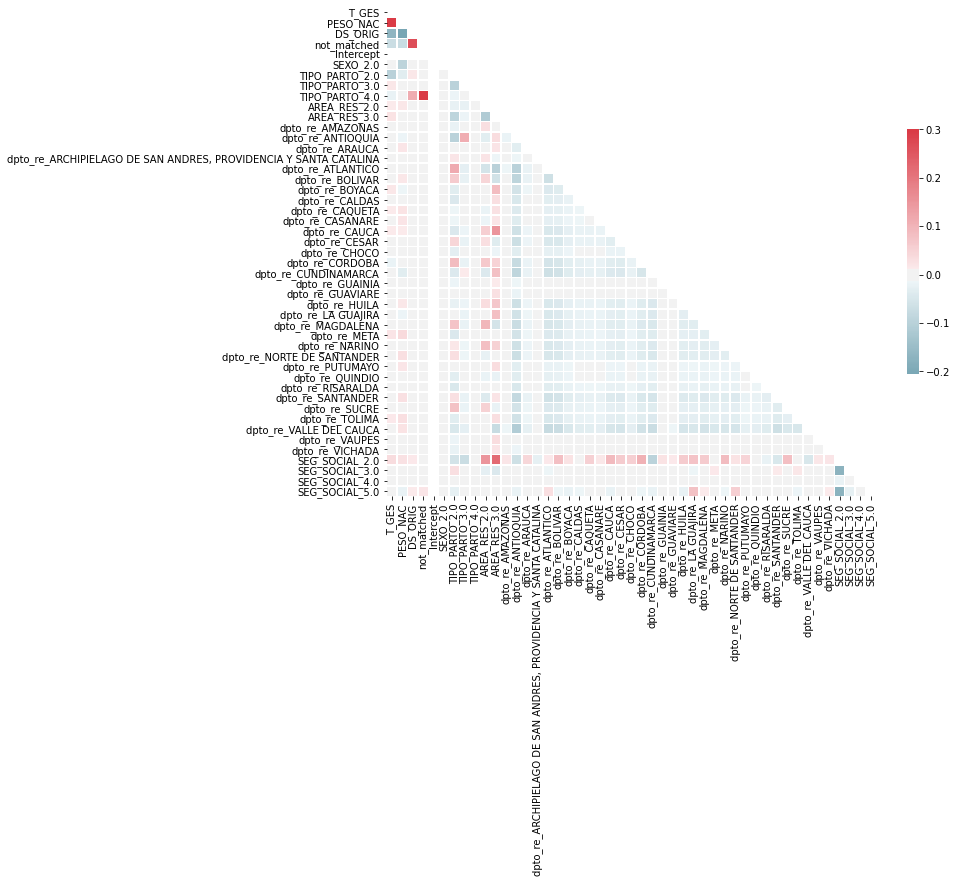

In [698]:
df_plot=df2.corr()
fig = plt.figure(figsize=(10,10))
mask = np.zeros_like(df_plot, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well
#mask[np.diag_indices_from(mask)] = False
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(df_plot, mask=mask, cmap=cmap, vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5})
# save to file
fig = sns_plot.get_figure()
fig.savefig('corr_dum')

## Balanceo

In [699]:
# Separate majority and minority classes
df_majority = df2[df2.DS_ORIG==0]
df_minority = df2[df2.DS_ORIG==1]
df_minority.shape[0]

6051

In [700]:
#Balancing classes
from sklearn.utils import resample
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.DS_ORIG.value_counts()
df2=df_downsampled
# 1    49
# 0    49
# Name: balance, dtype: int64

## Partición Train Test

In [701]:
#Split train test
np.random.seed(1337) 

ndata = len(df2)
# Randomly choose 0.8n indices between 1 and n
idx_train = np.random.choice(range(ndata),int(0.8*ndata),replace=False)
# The test set is comprised from all the indices that were
# not selected in the training set:
idx_test  = np.asarray(list(set(range(ndata)) - set(idx_train)))
df2_train     = df2.iloc[idx_train] # the training data set
df2_test      = df2.iloc[idx_test]  # the test data set
print(df2_train.shape) 
print(df2_test.shape)  

(9681, 47)
(2421, 47)


## Modelo

In [702]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

X_train=df2_train.drop(columns=['DS_ORIG','not_matched'])
y_train=df2_train['DS_ORIG']

logit2 = sm.Logit(y_train, X_train.astype(float))
logit_res2 = logit2.fit()
logit_res2.summary()

Optimization terminated successfully.
         Current function value: 0.465796
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DS_ORIG   No. Observations:                 9681
Model:                          Logit   Df Residuals:                     9636
Method:                           MLE   Df Model:                           44
Date:                Sun, 02 Aug 2020   Pseudo R-squ.:                  0.3280
Time:                        13:20:56   Log-Likelihood:                -4509.4
converged:                       True   LL-Null:                       -6710.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================================================
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
T_GES                                                               -0.2645      0.026    -10.238      0.000      -0.315      -0.214
PESO_NAC                                                            -0.7627      0.026    -29.250      0.000      -0.814      -0.712
Intercept                                                           -1.4438      0.088    -16.447      0.000      -1.616      -1.272
SEXO_2.0                                                            -0.2773      0.053     -5.268      0.000      -0.380      -0.174
TIPO_PARTO_2.0                                                       0.2387      0.055      4.321      0.000       0.130       0.347
TIPO_PARTO_3.0                                                      -0.1930      0.311     -0.620      0.535      -0.803       0.417
TIPO_PARTO_4.0                                                       5.3956      1.026      5.258      0.000       3.384       7.407
AREA_RES_2.0                                                        -0.0315      0.107     -0.295      0.768      -0.241       0.178
AREA_RES_3.0                                                         0.3846      0.078      4.905      0.000       0.231       0.538
dpto_re_AMAZONAS                                                     0.8628      0.580      1.489      0.137      -0.273       1.999
dpto_re_ANTIOQUIA                                                    0.3275      0.108      3.035      0.002       0.116       0.539
dpto_re_ARAUCA                                                       0.8635      0.333      2.590      0.010       0.210       1.517
dpto_re_ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA     1.7821      0.802      2.222      0.026       0.210       3.354
dpto_re_ATLANTICO                                                    0.3430      0.123      2.781      0.005       0.101       0.585
dpto_re_BOLIVAR                                                      0.4720      0.133      3.539      0.000       0.211       0.733
dpto_re_BOYACA                                                       0.1503      0.214      0.703      0.482      -0.269       0.569
dpto_re_CALDAS                                                       0.2016      0.237      0.851      0.395      -0.263       0.666
dpto_re_CAQUETA                                                      0.5738      0.251      2.285      0.022       0.082       1.066
dpto_re_CASANARE                                                     0.2903      0.302      0.961      0.337      -0.302       0.882
dpto_re_CAUCA                                                        0.3397      0.173      1.966      0.049       0.001       0.679
dpto_re_CESAR                                                        0.4371      0.156      2.804      0.005       0.132       0.743
dpto_re_CHOCO                                    

<Figure size 720x720 with 0 Axes>

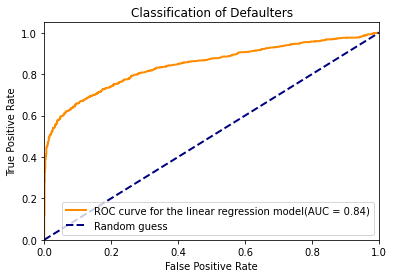

In [703]:
from sklearn import metrics, tree, ensemble
X_test=df2_test.drop(columns=['DS_ORIG','not_matched'])
y_test=df2_test['DS_ORIG']

# #Curva ROC del modelo de regresion logistica con dummies y sin departamento con region
pscoreLogit2 = logit_res2.predict(X_test.astype(float))
# plt.hist((pscoreLogit2),density=True, bins = 100);

fig = plt.figure(figsize=(10,10))
roc_p = metrics.roc_curve(df2_test['DS_ORIG'], pscoreLogit2)
auc_p = metrics.auc( roc_p[0], roc_p[1] )
plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for the linear regression model(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.savefig('roc.png')
plt.show()


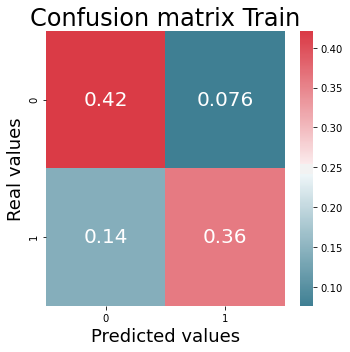

In [722]:
cm = logit_res2.pred_table(threshold=0.5)/len(X_train)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True,annot_kws={"size": 20},cmap=cmap)
# labels, title and ticks
plt.xlabel('Predicted values',fontsize=18)
plt.ylabel('Real values',fontsize=18)
plt.title('Confusion matrix Train',fontsize=24)
plt.tight_layout()
plt.savefig('cm.png')

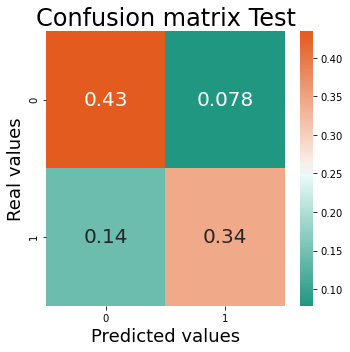

In [781]:
#cm = logit_res2.pred_table(threshold=0.5)/len(X_train)
pred = np.array(logit_res2.predict(X_test) > 0.5, dtype=float)
cm = np.histogram2d(y_test, pred, bins=2)[0]/len(X_test)
plt.figure(figsize=(5,5))

#cmap = sns.diverging_palette(168,22,s=94,l=56, as_cmap=True)#rgb(222,138, 90)
#cmap = sns.diverging_palette(168,36,s=94,l=56, as_cmap=True)#F8A528
#cmap = sns.diverging_palette(168,16,s=90,l=50,as_cmap=True)#rgb(202,86, 44)
#cmap = sns.diverging_palette(202,36,s=100,l=50,as_cmap=True)#rgb(202,86, 44)

sns.heatmap(cm, annot=True,annot_kws={"size": 20},cmap=cmap)
# labels, title and ticks
plt.xlabel('Predicted values',fontsize=18)
plt.ylabel('Real values',fontsize=18)
plt.title('Confusion matrix Test',fontsize=24)
plt.tight_layout()
plt.savefig('cm.png')

In [706]:
from sklearn import tree
tree_regressor=tree.DecisionTreeRegressor(max_depth=4)
dtree=tree_regressor.fit(X_train,y_train)
dtree

DecisionTreeRegressor(max_depth=4)

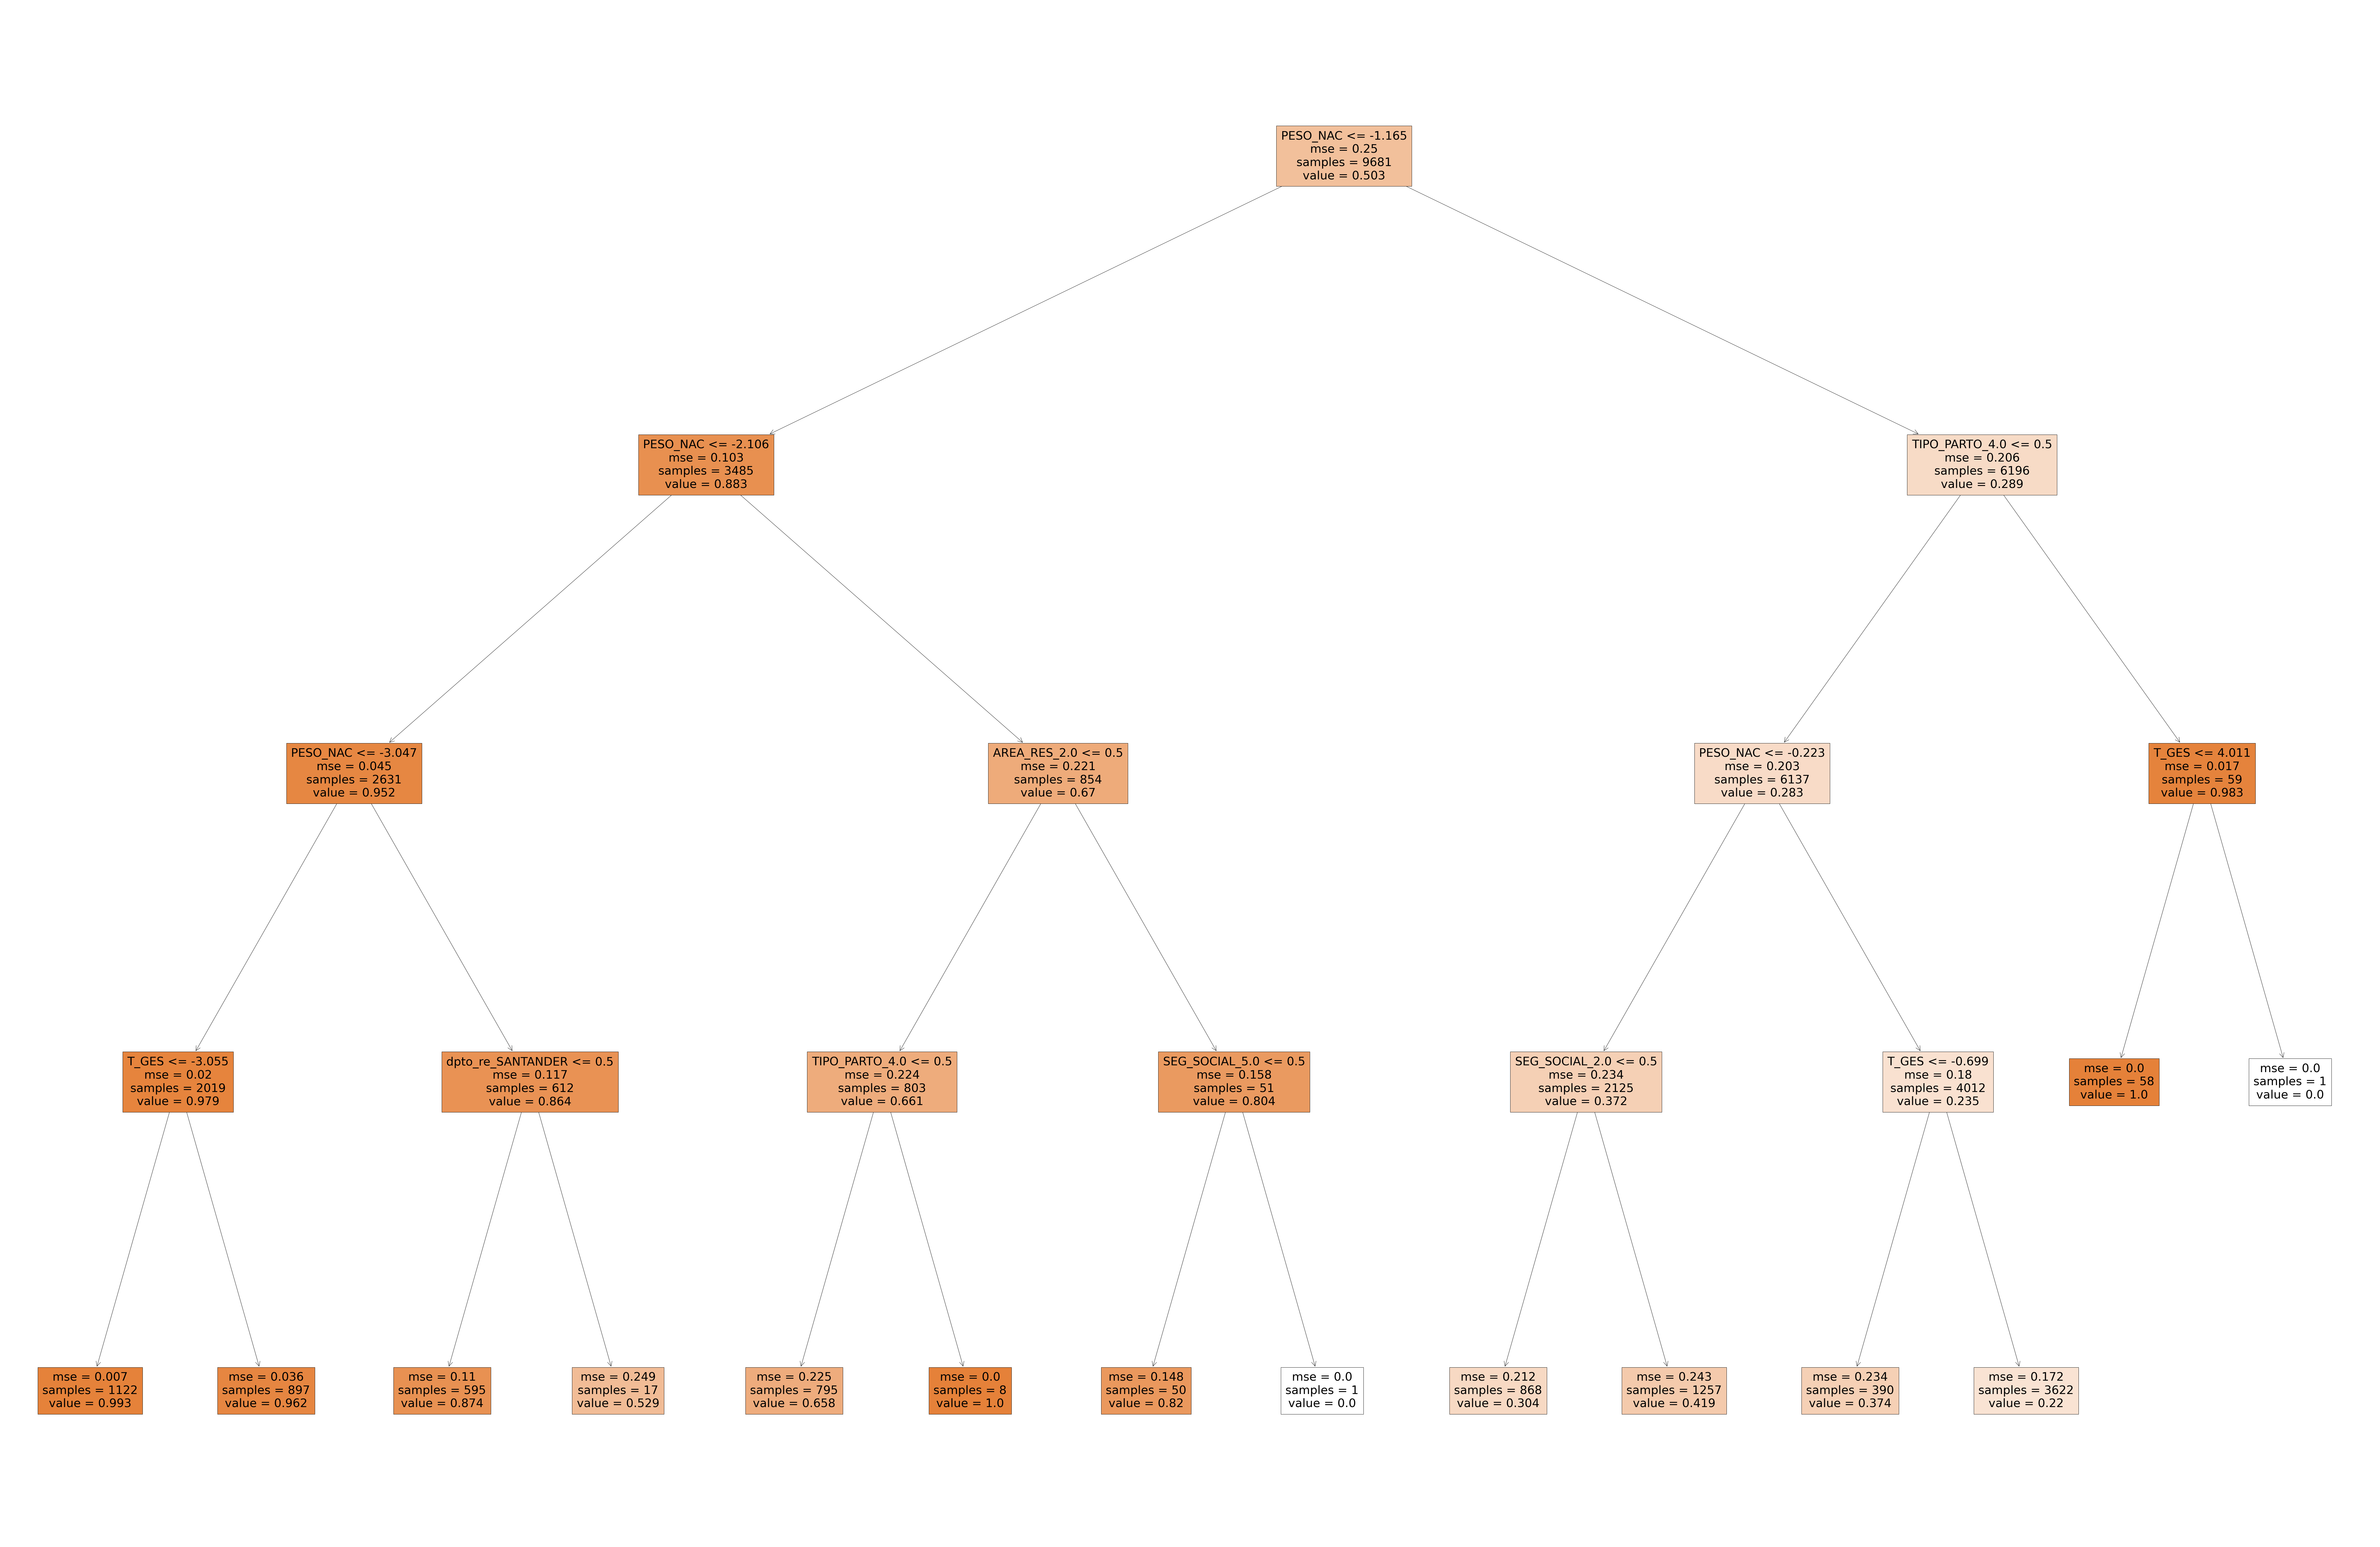

In [707]:
cols=X_train.columns
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dtree,filled=True,feature_names=cols)
fig.savefig('tree.png')

In [708]:
import graphviz

In [709]:
import os
os.environ["PATH"] += os.pathsep +'C:/Users/ssbarincon/AppData/Local/Continuum/anaconda3/Library/bin/graphviz'

In [710]:
dot_data = tree.export_graphviz(dtree,out_file=None,feature_names=cols,
                                class_names=['0','1'],filled=True, rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
#graph.render("Treeee")

In [711]:
df_infants.groupby(['dpto_re','CODPTORE']).size().sort_values()

dpto_re                                                   CODPTORE
VAUPES                                                    97            599
GUAINIA                                                   94            847
ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA  88            876
VICHADA                                                   99           1047
GUAVIARE                                                  95           1272
AMAZONAS                                                  91           1469
PUTUMAYO                                                  86           4592
ARAUCA                                                    81           4637
QUINDIO                                                   63           5920
CHOCO                                                     27           6461
CASANARE                                                  85           6481
CAQUETA                                                   18           7306
CALDAS               

In [712]:
df_infants.columns

Index(['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI', 'F_ID', 'DS_ORIG', 'DPTO_MUNIC', 'codigo_departamento',
       'codigo_dpto_mpio', 'nombre_departamento', 'nombre_municipio',
       'longitud', 'latitud', 'DPTO_MUNIC_RE', 'codigo_departamento_re',
       'codigo_dpto_mpio_re', 'dpto_re', 'nombre_municipio_re', 'longitud_re',
       'latitud_re', 'REGION', 'REGION_re', 'COD_DPTO_re', '_merge'],
      dtype='object')

---------

### Cols Merge

In [713]:
# cols_merge0=['COD_DPTO', 'COD_MUNIC', 'NOM_INST', 'COD_INST', 'SEXO', 'PESO_NAC',
#        'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
#        'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
#        'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
#        'IDCLASADMI']
cols_merge0=['COD_DPTO', 'COD_MUNIC', 'SEXO', 'PESO_NAC',
       'ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM', 'ULTCURMAD', 'CODPRES',
       'CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL',
       'IDCLASADMI']
cols_merge1=['SEXO', 'PESO_NAC','ANO', 'MES', 'T_GES', 'TIPO_PARTO', 'MUL_PARTO', 'IDPERTET',
       'EDAD_MADRE','CODPRES','CODPTORE', 'CODMUNRE', 'AREA_RES', 'N_HIJOSV', 'SEG_SOCIAL'] #Funciona decente
# cols_merge=['SEXO', 'PESO_NAC','ANO', 'MES', 'T_GES', 'TIPO_PARTO',
#        'EDAD_MADRE','CODPRES','CODPTORE', 'CODMUNRE', 'AREA_RES','SEG_SOCIAL'] #También funciona decente, cruzan más
# cols_merge=['SEXO', 'PESO_NAC','ANO', 'MES', 'T_GES', 'TIPO_PARTO',
#        'EDAD_MADRE','CODPRES','CODPTORE', 'AREA_RES','SEG_SOCIAL'] #Cruzan todavía más
# cols_merge=['COD_DPTO', 'SEXO', 'PESO_NAC','ANO', 'MES', 'T_GES', 'TIPO_PARTO',
#        'EDAD_MADRE','CODPRES','CODPTORE','SEG_SOCIAL'] #Cruzan todavía más
# cols_merge=['COD_DPTO', 'SEXO', 'PESO_NAC','ANO', 'MES', 'T_GES', 'TIPO_PARTO',
#        'EDAD_MADRE','CODPTORE']#,'SEG_SOCIAL'] #Cruzan todavía más
cols_merge2=['COD_DPTO','CODMUNRE', 'SEXO','ANO', 'MES', 'T_GES', 'TIPO_PARTO',
       'PESO_NAC','CODPTORE']#,'SEG_SOCIAL'] #Cruzan todavía más
cols_merge3=['COD_DPTO','CODMUNRE', 'SEXO','ANO', 'MES', 
       'CODPTORE']#,'SEG_SOCIAL'] #Cruzan todavía más
cols_merge=['COD_DPTO','CODPTORE','CODMUNRE','SEXO','ANO','MES','T_GES', 'TIPO_PARTO',
       'PESO_NAC','SEG_SOCIAL']

#,'IDCLASADMI'] does not make any difference

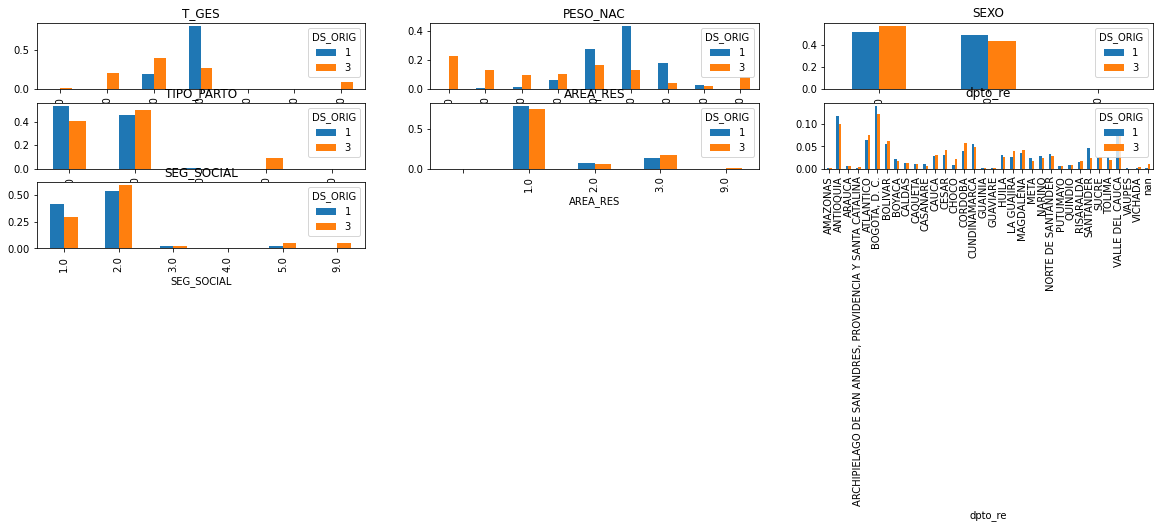

<Figure size 432x288 with 0 Axes>

In [784]:
# cols_plot=['COD_DPTO', 'SEXO', 'PESO_NAC', 'ANO', 'MES', 'T_GES', 'TIPO_PARTO',
#        'MUL_PARTO', 'IDPERTET', 'EDAD_MADRE', 'EST_CIVM', 'NIV_EDUM',
#        'ULTCURMAD', 'CODPRES', 'CODPTORE', 'AREA_RES', 'N_HIJOSV',
#        'SEG_SOCIAL', 'IDCLASADMI']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(model_cols):
    axi = fig.add_subplot(7,3,i+1)
    axi.set_title(col)
    df_plot = df_model.groupby(['DS_ORIG', col]).size().reset_index().pivot(columns='DS_ORIG', index=col, values=0)/df_model.groupby(['DS_ORIG']).size()
    df_plot.plot(kind='bar',ax=axi,)    
plt.tight_layout()
#plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()
plt.savefig('sample.pdf')

### Prueba match

In [715]:
a = [['a', 'A', 'B'], ['b', 'A', 'C'], ['c', 'A', 'C']]
b = [['a_', 'A', 'B'], ['b_', 'A', 'B'], ['x', 'A', 'C'],['y', 'A', 'C']]
df1 = pd.DataFrame(a, columns=['id_col', 'two', 'three'])
df2 = pd.DataFrame(b, columns=['id_col', 'two', 'three'])
df1['orig']=1
df2['orig']=2

df_merged = pd.concat([df1,df2])

In [716]:
df = pd.concat((df1, df2))
print(df.drop_duplicates('id_col'))

  id_col two three  orig
0      a   A     B     1
1      b   A     C     1
2      c   A     C     1
0     a_   A     B     2
1     b_   A     B     2
2      x   A     C     2
3      y   A     C     2


In [717]:
df1

,id_col,two,three,orig
0,a,A,B,1
1,b,A,C,1
2,c,A,C,1


In [718]:
df2

,id_col,two,three,orig
0,a_,A,B,2
1,b_,A,B,2
2,x,A,C,2
3,y,A,C,2


In [719]:
df_merged['one']=1
df_merged

,id_col,two,three,orig,one
0,a,A,B,1,1
1,b,A,C,1,1
2,c,A,C,1,1
0,a_,A,B,2,1
1,b_,A,B,2,1
2,x,A,C,2,1
3,y,A,C,2,1


In [720]:
df_merged=df_merged.assign(count=df_merged.groupby(['two','three','orig']).cumcount())
df_merged

,id_col,two,three,orig,one,count
0,a,A,B,1,1,0
1,b,A,C,1,1,0
2,c,A,C,1,1,1
0,a_,A,B,2,1,0
1,b_,A,B,2,1,1
2,x,A,C,2,1,0
3,y,A,C,2,1,1


In [721]:
df_merged.drop_duplicates(['two','three','count'])

,id_col,two,three,orig,one,count
0,a,A,B,1,1,0
1,b,A,C,1,1,0
2,c,A,C,1,1,1
1,b_,A,B,2,1,1
